In [1]:
# --- README --- #

# The Jupyter Notebook contains the practical Implementation of the Hints and Methods mentioned in:
# Information-Set Decoding with Hints by Anna-Lena Horlemann et. al (https://eprint.iacr.org/2021/279.pdf)
# and further attempts, techniques and hints, that I examined during the work for my Bachelor's Thesis.

# Disclamer: To prevent code duplications, the cells that are further down build on the upper ones.
#            This makes it necessary to partially execute the upper cells before using the lower ones.

# Included in this Jupyter Notebook are the following things:
# - Utility Functions for Partial Gaussian Eliminations, Approximation of the Distance of the Code by using the GV-Bound and more
# - A Generator for the Syndrome Decoding Problem (SDP), that uses the approximated distance to generate SDP Instances 
# - The ISD Algorithms of Prange, Lee-Brickell, Dumer-Stern and MMT (May, Meurer, Thomae)
# - The corresponding runtime and memory complexity of these ISD Algorithms
# - A flag, that can be set to generate the most efficient parameters for the ISD Algorithms Lee-Brickell, Stern, Dumer-Stern and MMT 
# - A Hints Generator, that generate of each mentioned Hint Type multiple instances at once 
# - The SDP Transformations, to generate smaller Instances of the SDP, mentioned in Information-Set Decoding with Hints
# - A Examination of Changes in runtime of Prange, when changing the parameters like in the Transformations and in general
# - The Modified Prange Algorithm with the mentioned Optimization Technique of Anna-Lena Horlemann et. al
# - The Modified Lee-Brickell Algorithm with the mentioned Optimization Technique of Anna-Lena Horlemann et. al
# - The Modified Stern Algorithm with the mentioned Optimization Technique of Anna-Lena Horlemann et. al
# - A Optimization for the SDP Transformation of Hint Type Six for Processing multiple hints at once
# - A Attempt for a stronger Transformation through multiple Hints of Hint Type Six 
# - A Hints Generator, that generate variants of the mentioned Hint Types; Also here multiple instances can be computed at once
# - Introducing a new Hint Type "Approximated Hints"
# - Implementing the BKW Algorithm optimizing the potential of the "Approximated Hints"
# - List Decoding for the Syndrome Decoding Problem
# - Attempts of Guessing Error Locations without using the Transformations + Success Probabilities and Resulting Runtimes
# - Attempts of Guessing Error Locations with using the Transformations + Success Probabilities and Resulting Runtimes
# - Attempts of Guessing Error-Free Locations with using the Transformations + Success Probabilities and Resulting Runtimes
# - Attempts Guessing Sub-Errors and their Hamming Weight + Success Probabilities and Resulting Runtimes

In [2]:
# --- UTILITY FUNCTIONS --- #

import numpy as np 
import copy
from sympy.utilities.iterables import multiset_permutations
from itertools import combinations

# Input: Matrix A ϵ GF(2)^(m x m)
# Output: is_invertable, inverted_matrix
#         If the matrix is invertable is_invertable is true and inverted_matrix is A^(-1)
#         If the matrix is not invertable is_invertable is false and invertable_matrix is []
def invert_matrix(A):
    dimension = A.nrows()
    
    if A.rank() != dimension:
        return False, []
    
    I = identity_matrix(dimension)
    A = A.augment(I)
    A = A.echelon_form()
    return True, A[:,dimension:]



# Input: Generator Matrix G ϵ GF(2)^(k x n)
# Output: Parity-Check Matrix P ϵ GF(2)^((n-k) x n)
def from_generator_to_parity_check(G):
    C = LinearCode(G)
    return C.parity_check_matrix()



# Input: Parity-Check Matrix P ϵ GF(2)^((n-k) x n)
# Input: Generator Matrix G ϵ GF(2)^(k x n)
def from_parity_check_to_generator(P):
    C_dual = LinearCode(P)
    return C_dual.parity_check_matrix()
    
    
    
# Input: A Errornous Codeword r = mG + e and Parity-Check Matrix P ϵ GF(2)^((n-k) x n)
# Output: Syndrome s
def from_errornous_codeword_to_syndrome(P, r):
    return P * r



# Input: Syndrome s and Parity-Check Matrix P ϵ GF(2)^((n-k) x n)   
# Output: A Errornous Codeword r = m'G + e   
def from_syndrome_to_errornous_codeword(P, s, k):
    P_copy = copy.copy(P)
    P_copy = P_copy.augment(s)
    P_copy.echelon_form()
    r_part = P_copy.columns()[-1]
    return vector(GF(2), chain(r_part, vector(GF(2), [0]*k)))
    


# Input: Dimension of the wanted Permutation Matrix (n x n)
# Output: Random Permutation Matrix of Dimension (n x n)
def permutation_matrix(dimension):
    permutation = np.random.permutation(int(dimension)) 
    H = zero_matrix(GF(2), dimension)
    for index in range(0,dimension):
        H[permutation[index],index] = 1
    return H 
    
    
    
# Input: Dimension of the vectors in GF(2) and the amount of ones 
# Output: All unique permutations in GF(2)^size with the stated number of ones 
def unique_permutations(size, ones):
    def bit_patterns(size, ones):
        for pos in map(set, combinations(range(size), ones)):
            yield [int(i in pos) for i in range(size)]
     
    permutations = []
    for element in bit_patterns(size, ones):
        permutations.append(vector(GF(2), element))
        
    return permutations 



# Input: Dimension of the output vectors in GF(2), the amount of ones and a values pool, where we can place the ones
# Output: All unique permutations in GF(2)^size with the stated number of ones and ones only in the values pool 
def unique_combinations(values, size, ones):
    def bit_patterns(size, ones):
        for pos in map(set, combinations(range(size), ones)):
            yield [int(i in pos) for i in range(size)]
     
    permutations = []
    for element in bit_patterns(len(values), ones):
        new_vector = vector(GF(2), size)
        counter = 0 
        for index in values:
            new_vector[index] = element[counter]
            counter += 1 
        
        permutations.append(new_vector)
        
    return permutations 
    


# Input: Parity-Check Matrix P of the Dimension (n-k x n) and Leon's l window
# Output: is_computable, semi_systematic_P, gaussian_opeations 
#         If the matrix is not computable is_computable is true and semi_systematic_P is P in semi-systematic form 
#         If the matrix is not computable is_computable is false and semi_systematic_P is []
#         gaussian_operations is a Matrix G, that holds all Gaussian Operations, that have be done 
def compute_semi_systematic_form(P, n, k, l):
    if rank(P) <= n-k-l:
        return False, [], []
    
    G = identity_matrix(GF(2), n-k)
    for current_row in range(0,n-k-l):
        new_up = 0 
        for candidate in range(current_row, n-k):
            if P[candidate, current_row] == 1:
                new_up = candidate 
                break

        if new_up != current_row: 
            P.swap_rows(new_up, current_row)
            G.swap_rows(new_up, current_row)
            
        for delete in range(0, n-k):
            if delete == current_row: 
                continue
            
            if P[delete, current_row] == 1: 
                P[delete] = P[delete] + P[current_row]
                G[delete] = G[delete] + G[current_row] 
    
    semi_systematic_P = P
    gaussian_operations = G
    
    return True, semi_systematic_P, gaussian_operations



# Input: Length of the vector and amount_of_vectors
# Output: amount_of_vectors random measurement vectors v_i GF(2)^length\{0}, that are linearly independent 
def generate_linearly_independent_v(length, amount_of_vectors):
    vectors = []
    check_up = []
    for index in range(1, amount_of_vectors+1):
        check_up = copy.copy(vectors)
        while True:
            amount_ones = np.random.randint(1,length)
            sample_v = [0]*int(length-amount_ones) + [1]*amount_ones
            v = vector(GF(2), sample_v)
            shuffle(v)
            check_up.append(v)
            
            check_up_matrix = matrix(GF(2), check_up)
            if rank(check_up_matrix) == index:
                vectors.append(v)
                break 
       
    return vectors



# Input: Parity-Check Matrix P of the Dimensions (n-k) x n and amount_of_vectors
# Output: amount_of_vectors measurement vectors v_i ϵ GF(2)^n\{0}, that are linearly independent together with the rows of P as Array 
def generate_linearly_independent_v_with_P(P, n, k, amount_of_vectors):
    vectors = []
    updated_P = copy.copy(P)
    check_up_P = copy.copy(P)
    
    for index in range(1, amount_of_vectors+1):
        while True:
            amount_ones = np.random.randint(1,n)
            sample_v = [0]*int(n-amount_ones) + [1]*amount_ones 
            v = vector(GF(2), sample_v)
            shuffle(v)
            
            check_up_P = copy.copy(updated_P)
            check_up_P = check_up_P.transpose()
            check_up_P = check_up_P.augment(v)
            check_up_P = check_up_P.transpose()
            
            if rank(check_up_P) == n-k+index:
                vectors.append(v)
                updated_P = copy.copy(check_up_P)
                break 
                
    return vectors


    
# Input: A vector v ϵ GF(2)^k\{0} and position x 
# Output: A invertable matrix A ϵ GF(2)^(k x k), so that A * v = d_(x), where d_x is the unit vector 
#         >> MANDATORY FOR TRANSFORMATION OF HINT TYPE 6
# Disclamer: Very naive Implmentation, by using the randomness of random_matrix()
def generate_matrix_A(v, k, x):
    while True:
        if len(v) != k:
            return "ERROR!"
        
        A = random_matrix(GF(2), k, k)
       
        for row in range(k):
            # Checking & Modifiying the Matrix in the Rows, that are not x
            if row != x:
                current_row_tuple = A[row, :]
                current_row = vector(GF(2), [0]*k)
                for index in range(k):
                    current_row[index] = current_row_tuple[0][index]
                
                if v.dot_product(current_row) == 0:
                    continue
                
                for column in range(k):
                    if A[row, column] == 1 and v[column] == 1:
                        A[row, column] = 0 
                        break 
                
            else: 
                # Checking & Modifying the Matrix in the Row x
                x_row_tuple = A[x, :]
                x_row = vector(GF(2), [0]*k)
                for index in range(k):
                    x_row[index] = x_row_tuple[0][index]
        
                if v.dot_product(x_row) == 0:
                    for column in range(k):
                        if A[x, column] == 0 and v[column] == 1:
                            A[x, column] = 1
                            break 
                        
        if rank(A) == k:
            return A 

        
        
# Input: The Size of the Set, that should be divided into amount_partitions almost equal size partitions
# Output: Cardinalities of the Partitions        
def create_equal_partition(amount_partitions, n):
    W = list(np.arange(n))
    partitions = np.array_split(W, amount_partitions)  
    cardinalities = []
    for index in range(amount_partitions):
        cardinalities.append(len(partitions[index]))
        
    return cardinalities


        
# Input: The amount_partitions and the range of values delimited by n so range(0, n)        
# Output: Partitions Array, that holds the cardinality of the partitions        
def create_random_partition(amount_partitions, n):
    while True:
        partitions = []
        for index in range(amount_partitions):
            partitions.append(np.random.randint(1, n))
        
        in_total = sum(partitions)
        
        if in_total < n: 
            continue 
            
        while in_total > n:
            random_index = np.random.randint(0, amount_partitions)
            
            if partitions[random_index] == 1:
                continue
            
            partitions[random_index] = partitions[random_index] - 1
            in_total = in_total - 1
            
        return partitions
    

    
# Input: A value target, that determines how large the sum should be and the length l of the sum
# Output: Returns a array with all possible lists of size l, that have as sum target
def all_possible_sums(target, l):
    def all_possible_sums_rec(target, current_sum, start, output, result):
        if current_sum == target:
            output.append(copy.copy(result))

        for i in range(start, target):
            temp_sum = current_sum + i
            if temp_sum <= target:
                result.append(i)
                all_possible_sums_rec(target, temp_sum, i, output, result)
                result.pop()
            else:
                return
    
    if target < 1:
        return None
    
    if target == 1:
        permutations = unique_permutations(l, target)
        all_possible_sums_length_l = []
        for permutation in permutations:
            all_possible_sums_length_l.append(list(permutation))
            
        return all_possible_sums_length_l    
    
    sums = []
    all_possible_sums_rec(target, 0, 1, sums, [])
    sums_length_l = []
    
    for candidate in sums:
        if len(candidate) > l:
            continue
         
        if len(candidate) == l:
            sums_length_l.append(candidate)
        else:
            zero_list = [0]*(l-len(candidate))
            sums_length_l.append(candidate + zero_list)
        
    all_possible_sums_length_l = []
    for sum_l in sums_length_l:
         all_possible_sums_length_l += list(multiset_permutations(sum_l))
            
    return all_possible_sums_length_l



# Input: Value p between 0 and 1 
# Output: Binary Entropy of p 
def binary_entropy(p):
    if p < 0 or p > 1:
        return "p has to be between 0 and 1!"
    
    if p == 0 or p == 1:
        return 0 

    return float((-p)*log(p, 2) - (1-p)*log(1-p, 2))
    
    
    
# Input: Parameters n and k of the Linear Code
# Output: Approximated Distance by the GV Bound 
def approximate_distance(n,k):    
    d = 0
    boundary_value = float(1 - k/n)
    while True:
        if d == n:
            return n
        
        current_binary_entropy = binary_entropy(float(d/n))
        # Since the Distance Approximation is not precise by the GV-Bound we use a factor of 1.05 to 
        # ensure, that this approximation satisfy, that the smallest McEliece Instance n = 3488, k = 2720, w = 64 is unique decodable!
        if current_binary_entropy > boundary_value * 1.05:
            return d 
        else:
            d += 1 
    

    
# Input: Parameters n and k of the Linear Code     
# Output: Approximated Packing Radius through GV-Bound
def approximated_packing_radius(n,k):
    d = approximate_distance(n,k)
    if d == 0:
        return 0 
    packing_radius = floor((d-1)/2)
    return packing_radius



# Input: Parameters n, k and w = wt_H(e)
# Output: Estimating whether Decoding is unique through GV-Bound
def is_unique_decoding(n, k, w):
    estimated_w = approximated_packing_radius(n,k)
    if estimated_w >= w:
        return True
    
    return False



# Input: N "Grundgesamtheit", M the amount of successes, n the amount of samples and k the expected amount of successes
# Output: P(X = k) for the hypergeometric distribution
def hypergeometric_distribution(N, M, n, k):
    nominator = binomial(M, k) * binomial(N-M, n-k)
    denominator = binomial(N, n)
    return nominator/denominator 

In [3]:
# --- RUNTIME AND SPACE COMPLEXITIES --- #

# Input: Dimensions n,k and w(e)= w     
# Output: Resulting Runtime Complexity of Prange's ISD algorithm 
def runtime_complexity_prange(n, k, w):
    return binomial(n, w) / binomial(n-k, w)



# Input: Dimensions n,k and w(e)= w     
# Output: Resulting Logarithmic to the Base of 2 Runtime Complexity of Prange's ISD algorithm 
def logarithmic_runtime_complexity_prange(n, k, w):
    return ceil(binary_entropy(w/n) * n - binary_entropy(w/(n-k)) * (n-k))
    

    
# Input: Dimensions n,k , outside weight p with p<w and w(e)= w
# Output: Resulting Runtime Complexity of Lee-Brickell ISD 
def runtime_complexity_lee_brickell(n, k, w, p):
    return binomial(n, w) / binomial(n-k, w-p)



# Input: Dimensions n,k , inside weight p with 2p <= w, w(e)= w, Leon's l window
# Output: Resulting Runtime Complexity of Stern ISD 
def runtime_complexity_isd_stern(n, k, w, p, l):
    dividend = binomial(n, w)*max(1, binomial(floor(k/2), p)**2 *pow(2, -l))
    divisor = binomial(n-k-l, w-2*p) * binomial(floor(k/2), p)
    if divisor == 0:
        return None 
    
    return dividend / divisor



# Input: Dimension k and inside weight p
# Output: Resulting Memory Complexity of Stern ISD
def memory_complexity_isd_stern(k, p):
    return binomial(floor(k/2), p)



# Input: Dimensions n,k , outside weight p with p<w, w(e)= w, Leon's l window
# Output: Resulting Runtime Complexity of Dumer-Stern ISD 
def runtime_complexity_dumer_stern(n, k, w, p, l):
    dividend = binomial(n, w)*max(1, binomial((k+l)/2, p/2)*pow(2, -l))
    divisor = binomial(n-k-l, w-p) * binomial((k+l)/2, p/2)
    if divisor == 0:
        return None 
    
    return dividend / divisor
                    

    
# Input: Dimension k, outside weight p and Leon's l window
# Output: Resulting Memory Complexity of Dumer-Stern ISD 
def memory_complexity_dumer_stern(k, p, l):
    return binomial((k+l)/2, p/2)
    

    
# Input: Dimensions n,k , outside weight p with p<w, w(e)= w, Leon's l window
# Output: Resulting Runtime Complexity of MMT ISD    
def runtime_complexity_mmt(n, k, w, p, l):
    dividend = binomial(n, w) * binomial(k+l, p/2) * max(1, binomial(k+l, p/2) * pow(2, l-p) / binomial(p, p/2))
    divisor = binomial(n-k-l, w-p) * binomial(k+l, p) * binomial(p, p/2)
    if divisor == 0:
        return None 
    
    return dividend / divisor 



# Input: Dimensions k, outside weight p and Leon's l window
# Output: Resulting Memory Complexity of MMT ISD 
def memory_complexity_mmt(k, p, l):
    return binomial(k+l, p/2) / binomial(p, p/2)

In [4]:
# --- CREATING A INSTANCE OF THE SYNDROME DECODING PROBLEM (SDP) --- #

from numpy import random 

# Input: Dimensions n,k and the hamming weight of the error notated w 
# Output: Parity Check Matrix P, Generator Matrix G, Syndrome s, Message r = mG+e, the Error e and m 
# >> We need there everything to generate hints and having the possibility to switch between the two forms of the SDP
#    First Form - Given here is P and s
#    Second Form - Given here is G and r 
def generate_syndrome_decoding_problem(n, k, w):
    G = zero_matrix(GF(2), n, k)
    while G.rank() != k:
        G = random_matrix(GF(2), k, n)
        
    C = LinearCode(G)
    P = C.parity_check_matrix()
    
    amount_ones = random.randint(1, k)
    sample_m = [0]*int(k-amount_ones) + [1]*int(amount_ones)
    m = vector(GF(2), sample_m)
    shuffle(m)
    c = C.encode(m)
    
    sample_e = [0]*int(n-w) + [1]*int(w)
    e = vector(GF(2), sample_e)
    shuffle(e)
    s = P * e
    r = vector(GF(2), c + e)
    
    return P, G, s, r, e, m 



# --- USAGE --- #
n = 237
k = 124
w = approximated_packing_radius(n,k)
P, G, s, r, e, m = generate_syndrome_decoding_problem(n, k, w)

In [5]:
# --- IMPLEMENTATION OF THE INFORMATION-SET DECODING ALGORITHM OF PRANGE --- #    

import random
from itertools import chain
 
# Input: Generator Matrix G, Errornous Codeword r = mG + e, Dimensions n,k and w(e)= w 
# Output: Error Vector e  
def isd_primal_prange(G, r, n, k, w):
    success = False
    
    while not success:
        I = sorted(random.sample(list(range(n)), k))
    
        if G[:, I].rank() != k:
            continue 

        G_I = G[:, I]
        G_I_inverse = G_I.inverse()
        
        r_modified = vector(GF(2), k)
        counter = 0
        for value in I:
            r_modified[counter] = r[value]
            counter += 1 
            
        G_new = G_I_inverse * G
        calculated_e = r + r_modified * G_new
                
        if calculated_e.hamming_weight() == w:
            return calculated_e  
        
        

# Input: Parity-Check Matrix P, Syndrome s, Dimensions n,k and w(e)= w 
# Output: Error e
def isd_dual_prange(P, s, n, k, w):
    finished_step1 = False
    
    while not finished_step1:
        finished_step2 = False
        
        while not finished_step2:
            H = permutation_matrix(n)
            PH = P * H
            P1 = PH[:,:int(n-k)]
            is_invertable, P1_inverted = invert_matrix(P1)
            
            if is_invertable:
                finished_step2 = True
                
        e1 = P1_inverted * s
        if e1.hamming_weight() == w:
            finished_step1 = True
            solution_vector = vector(GF(2), chain(e1, vector(GF(2), [0]*k)))
            e_calculated = H * solution_vector
            return e_calculated 
    
 
    
# --- USAGE --- #   
# Note: The hamming weight w of the Error e is smaller as the approximated packing radius to decrease the runtime of the algorithms.
#       The algorithms also compute the Error e or the Message m when choosing as hamming weight, the packing radius! 
n = 237
k = 124
w = int(approximated_packing_radius(n,k)/2)
P, G, s, r, e, m = generate_syndrome_decoding_problem(n, k, w)  

primal_e = isd_primal_prange(G, r, n, k, w)
if e == primal_e:
    print("PRIMAL PRANGE WAS SUCCESFUL!")

dual_e = isd_dual_prange(P, s, n, k, w)
if e == dual_e:
    print("DUAL PRANGE WAS SUCCESFUL!")

PRIMAL PRANGE WAS SUCCESFUL!


DUAL PRANGE WAS SUCCESFUL!


In [6]:
# --- IMPLEMENTATION OF THE INFORMATION-SET DECODING ALGORITHM OF LEE AND BRICKELL --- #

import random 
from itertools import chain

# Input: - 
# Output: Optimal Choice for p to minimize the Runtime Complexity; We know it's 0 - 0
def optimal_runtime_complexity_lee_brickell():
    optimal_p = 0      
    return optimal_p
        
    
    
# Input: Generator Matrix G, Errornous Codeword r = mG + e, Dimensions n, k, w(e)= w, p the amount of error locations in the information set and the optimal flag            
# Output:            
def isd_primal_lee_brickell(G, r, n, k, w, p, optimal):
    if p > w:
        return "p has to be smaller or equal w!"

    if optimal:
        p = optimal_runtime_complexity_lee_brickell() 
    
    success = False
    while not success:
        I = sorted(random.sample(list(range(n)), k))

        G_I = G[:, I]
        
        if rank(G_I) != k:
            continue
                
        G_I_inverse = G_I.inverse()
        
        r_modified = vector(GF(2), k)
        counter = 0
        for value in I:
            r_modified[counter] = r[value]
            counter += 1 
            
        G_new = G_I_inverse * G
        e_I = r + r_modified * G_new
                
        # Second Step
        if p == 0:
            if e_I.hamming_weight() == w:
                return e_I
        
        epsilons = unique_permutations(k, p)
        for candidate in epsilons:
            e_I_modified = e_I + candidate * G_new
            if e_I_modified.hamming_weight() == w:
                return e_I_modified   

            
            
# Input: Parity-Check Matrix P, Syndrom s, Dimensions n,k and w(e)= w, outside weight p and the optimal flag
#        >> When the optimal flag is set, the optimal choice for p is calculated 
# Output: Error e
def isd_dual_lee_brickell(P, s, n, k, w, p, optimal):
    if optimal:
        p = optimal_runtime_complexity_lee_brickell()
        
    finished_step1 = False
    
    while not finished_step1:
        finished_step2 = False
        
        while not finished_step2:
            H = permutation_matrix(n)
            PH = P * H
            P1 = PH[:,:int(n-k)]
            P2 = PH[:, int(n-k):]
            is_invertable, P1_inverted = invert_matrix(P1)
            
            if is_invertable:
                finished_step2 = True
                
        for e2 in unique_permutations(k, p):
            e1 = P1_inverted*s + P1_inverted * P2 * e2
            if e1.hamming_weight() == w-p:
                finished_step1 = True
                solution_vector = vector(GF(2), chain(e1, e2))
                e_calculated = H * solution_vector
                return e_calculated             
            
            


# --- USAGE --- #            
n = 237
k = 124
w = int(approximated_packing_radius(n,k)/2)
p = 1 
P, G, s, r, e, m = generate_syndrome_decoding_problem(n, k, w)  

print("THE OPTIMAL CHOICE OF THE PARAMETER P IS: P =", optimal_runtime_complexity_lee_brickell())
primal_e = isd_primal_lee_brickell(G, r, n, k, w, p, False)
if e == primal_e:
    print("PRIMAL LEE-BRICKELL WAS SUCCESFUL!")

dual_e = isd_dual_lee_brickell(P, s, n, k, w, p, False)   
if e == dual_e:
    print("DUAL LEE-BRICKELL WAS SUCCESFUL!")

THE OPTIMAL CHOICE OF THE PARAMETER P IS: P = 0


PRIMAL LEE-BRICKELL WAS SUCCESFUL!


DUAL LEE-BRICKELL WAS SUCCESFUL!


In [7]:
# --- IMPLEMENTATION OF THE INFORMATION-SET DECODING ALGORITHM OF STERN --- #

import random
import itertools 
from collections import defaultdict 

# Input: Dimension n,k and w(e)= w
# Output: Optimal Choice for p and l to minimize the Runtime Complexity 
def optimal_runtime_complexity_isd_stern(n, k, w):
    optimal_l, optimal_p = 1, 1
    lowest_complexity = None
    
    for p in range(1, floor(w/2)):
        # We have to subtract w-p because the upper factor in the binomial coefficient has to be greater or equal w-p
        # Otherwise the Binomial Coefficient cannot be calculated
        for l in range(1, n-k):
            current_complexity = runtime_complexity_isd_stern(n, k, w, p, l) 
            if current_complexity == None:
                continue 
                
            if lowest_complexity == None or lowest_complexity > current_complexity:
                optimal_l, optimal_p = l, p
                lowest_complexity = current_complexity
    
    return optimal_l, optimal_p



# Input: Generator Matrix G, Errornous Codeword r = mG + e, Dimensions n and k, the weight of the error w, inside weight p with 2p <= w, Leon's l window and the optimal flag
# Output: Error e
def isd_stern(G, r, n, k, w, l, p, optimal):
    if optimal:
        l, p = optimal_runtime_complexity_isd_stern(n, k, w)
    
    success = False
    while not success:
        potential_values = list(range(n))
        I = sorted(random.sample(potential_values, k))
    
        if G[:, I].rank() != k:
            continue 
    
        r_I = vector(GF(2), k)
        counter = 0
        for value in I:
            r_I[counter] = r[value]
            counter += 1 
            
        G_new = G[:, I].inverse() * G
        r_modified = r + r_I * G_new 
        
        X = sorted(random.sample(I, floor(k/2)))
        Y = sorted(list(filter(lambda a: a not in X, I))) 
        Z = sorted(random.sample(list(filter(lambda a: a not in I, potential_values)), l))
        values_A = []
        values_B = []
        
        counter = 0
        for element in I:
            if element in X:
                values_A.append(counter)
            else:
                values_B.append(counter)
            counter += 1
        
        phi_A = defaultdict(list)
        for current_vector in unique_combinations(values_A, k, p):
            value_phi_A = []
            result = r_modified + (current_vector * G_new)
            for index in Z:
                value_phi_A.append(result[index])
            phi_A[repr(value_phi_A)].append(current_vector * G_new)
        
        for candidate in unique_combinations(values_B, k, p):
            result = candidate * G_new
            value_psi_B = []
            for index in Z:
                value_psi_B.append(result[index])
            
            for sum_phi_A in phi_A[repr(value_psi_B)]:
                e = r_modified + sum_phi_A + result
                if e.hamming_weight() == w:
                    return e 

             
      
    
# --- USAGE --- #                 
n = 237
k = 124
w = int(approximated_packing_radius(n,k)/2)
P, G, s, r, e, m = generate_syndrome_decoding_problem(n, k, w)

l, p = optimal_runtime_complexity_isd_stern(n, k, w)

print("THE OPTIMAL CHOICES OF THE PARAMETER L AND P ARE: L =", l, ", P =", p)

calculated_e = isd_stern(G, r, n, k, w, l, p, False)
if e == calculated_e:
    print("ISD STERN WAS SUCCESFUL!")

THE OPTIMAL CHOICES OF THE PARAMETER L AND P ARE: L = 12 , P = 1


ISD STERN WAS SUCCESFUL!


In [8]:
# --- IMPLEMENTATION OF THE INFORMATION-SET DECODING ALGORITHM OF DUMER AND STERN --- #

from itertools import chain
from collections import defaultdict

# Input: Dimension n,k and w(e)= w
# Output: Optimal Choice for p and l to minimize the Runtime Complexity 
def optimal_runtime_complexity_dumer_stern(n, k, w):
    optimal_l, optimal_p = 1, 2
    lowest_complexity = None
    
    for p in range(2, w+1, 2):
        # We have to subtract w-p because the upper factor in the binomial coefficient has to be greater or equal w-p
        # Otherwise the Binomial Coefficient cannot be calculated
        for l in range(1, n-k-(w-p)+1):
            if (l+k)%2 == 0:
                current_complexity = runtime_complexity_dumer_stern(n, k, w, p, l) 
                if current_complexity == None:
                    continue 
                
                if lowest_complexity == None or lowest_complexity > current_complexity:
                    optimal_l, optimal_p = l, p
                    lowest_complexity = current_complexity
    
    return optimal_l, optimal_p



# Input: Parity-Check Matrix P, Syndrom s, Dimension n,k and w(e)= w, outside weight p, Leon's l window and the optimal flag
#        >> When the optimal flag is set, the optimal choice for p and l is calculated 
# Output: Error e   
def isd_dumer_stern(P, s, n, k, w, l, p, optimal):
    if optimal:
        l, p = optimal_runtime_complexity_dumer_stern(n, k, w)
      
    if p%2 != 0:
        return "p has to be even!"
    
    if p < 2:
        return "p has to be at least 2!"
    
    if (k+l)%2 != 0:
        return "The sum of k+l has to be even!"
    
    success = False
    size_e2_e3 = int((k+l)/2)
    ones_e2_e3 = int(p/2)
    
    while not success:
        H = permutation_matrix(n)
        PH = P * H
        is_computable, semi_systematic_P, gaussian_opeations = compute_semi_systematic_form(PH, n, k, l)
        
        if not is_computable:
            continue
        
        A, B = semi_systematic_P[:int(n-k-l),int(n-k-l):], semi_systematic_P[int(n-k-l):,int(n-k-l):]
        A1, A2 = A[:,:int((k+l)/2)], A[:,int((k+l)/2):]
        B1, B2 = B[:,:int((k+l)/2)], B[:,int((k+l)/2):]
    
        Gs = gaussian_opeations * s
        s1, s2 = Gs[:int(n-k-l)], Gs[int(n-k-l):]
        
        L = defaultdict(list)
        for e2 in unique_permutations(size_e2_e3, ones_e2_e3):
            L[repr(B1 * e2)].append(e2)
            
        for e3 in unique_permutations(size_e2_e3, ones_e2_e3):
            match = s2 + B2*e3
            for e2 in L[repr(match)]:
                e1 = A1*e2 + A2*e3 + s1
                if e1.hamming_weight() == w-p:
                    solution_vector = vector(GF(2), chain(e1, e2, e3))
                    e = H * solution_vector
                    return e 


                
# --- USAGE --- #                
n = 237
k = 124
w = int(approximated_packing_radius(n,k)/2)
P, G, s, r, e, m = generate_syndrome_decoding_problem(n, k, w)

l, p = optimal_runtime_complexity_dumer_stern(n, k, w)
print("THE OPTIMIZED VALUES FOR THE PARAMETERS L AND P ARE: L =", l, "AND P =", p)

calculated_e = isd_dumer_stern(P, s, n, k, w, l, p, False)
if e == calculated_e: 
    print("ISD DUMER STERN WAS SUCCESFUL!")

THE OPTIMIZED VALUES FOR THE PARAMETERS L AND P ARE: L = 6 AND P = 2


ISD DUMER STERN WAS SUCCESFUL!


In [9]:
# --- IMPLEMENTATION OF THE INFORMATION-SET DECODING ALGORITHM MMT --- #

from itertools import chain
from collections import defaultdict

# Input: Dimension n,k and w(e)= w
# Output: Optimal Choice for p and l to minimize the Runtime Complexity 
def optimal_runtime_complexity_mmt(n, k, w):
    optimal_l, optimal_p = 1, 2
    lowest_complexity = None
    
    for p in range(2, w+1, 2):
        # We have to subtract w-p because the upper factor in the binomial coefficient has to be greater or equal w-p
        # Otherwise the Binomial Coefficient cannot be calculated
        for l in range(p+1, n-k-(w-p)+1):
            current_complexity = runtime_complexity_mmt(n, k, w, p, l) 
                
            if lowest_complexity == None or current_complexity <= lowest_complexity:
                optimal_l, optimal_p  = l, p
                lowest_complexity = current_complexity

    return optimal_l, optimal_p



# Input: Parity-Check Matrix P, Syndrom s, Dimension n,k and w(e)= w, outside weight p, Leon's l window and the optimal flag
#        >> When the optimal flag is set, the optimal choice for p and l is calculated 
# Output: Error e    
def isd_mmt(P, s, n, k, w, l, p, optimal):
    if optimal:
        l, p = optimal_runtime_complexity_mmt(n, k, w)
    
    if p%2 != 0:
        return "p has to be even!"
    
    if p < 2:
        return "p has to be at least 2!"
    
    if l < p:
        return "l has to be at least as great as p!"
    
    success = False
    size_e2_e3 = int(k+l)
    ones_e2_e3 = int(p/2)
    
    while not success: 
        H = permutation_matrix(n)
        PH = P * H
        is_computable, semi_systematic_P, gaussian_opeations = compute_semi_systematic_form(PH, n, k, l)
        
        if not is_computable:
            continue
        
        A, B = semi_systematic_P[:int(n-k-l),int(n-k-l):], semi_systematic_P[int(n-k-l):,int(n-k-l):]
        
        Gs = gaussian_opeations * s
        s1, s2 = Gs[:int(n-k-l)], Gs[int(n-k-l):]
          
        L1 = defaultdict(list)
        for e2 in unique_permutations(size_e2_e3, ones_e2_e3):
            value = B * e2
            if value[:p] == vector(GF(2), [0]*p):
                 L1[repr(value)].append(e2)
        
        
        L2 = defaultdict(list)
        for e3 in unique_permutations(size_e2_e3, ones_e2_e3):
            value = s2 + B * e3
            if value[:p] == vector(GF(2), [0]*p):
                 L2[repr(value)].append(e3)
               
        for Be2, e2 in L1.items():
            for e3 in L2[Be2]:
                sum_e2e3 = vector(GF(2), vector(GF(2), e2[0]) + vector(GF(2), e3))
                e1 = A * sum_e2e3 + s1
                if e1.hamming_weight() == w-p:
                    solution_vector = vector(GF(2), chain(e1, sum_e2e3))
                    e = H * solution_vector
                    return e 
                        

                    
                    
# --- USAGE --- # 
n = 237
k = 124
w = int(approximated_packing_radius(n,k)/2)
P, G, s, r, e, m = generate_syndrome_decoding_problem(n, k, w)

l = 20
p = 2 

l_optimized, p_optimized = optimal_runtime_complexity_dumer_stern(n, k, w)
print("THE OPTIMIZED VALUES FOR THE PARAMETERS L AND P ARE: L =", l_optimized, "AND P =", p_optimized)

calculated_e = isd_mmt(P, s, n, k, w, l, p, False)
if e == calculated_e:
    print("ISD MMT WAS SUCCESFUL!")

THE OPTIMIZED VALUES FOR THE PARAMETERS L AND P ARE: L = 6 AND P = 2


ISD MMT WAS SUCCESFUL!


In [10]:
# --- CREATING HINT INSTANCES, MENTIONED IN INFORMATION-SET DECODING WITH HINTS --- #
# --- THESE HINTS ARE ALL DEFINED OVER GF(2) -- #

import numpy as np

# Input: Error e ϵ GF(2)^n and amount_of_hints
# Output: amount_of_hints random error locations j as Numpy Array
# >> Since we are defining the hints over GF(2), we know, that a error entry has the value 1. For this reason, we output in this hint the error location of the error
def hint_type_one_two(n, e, amount_of_hints):
    if amount_of_hints > e.hamming_weight():
        return "The requested amount of hints is bigger than the amount of error locations in e!"
    
    indices = []
    for index in range(0,n):
        if e[index] == 1:
            indices.append(index)
            
    return np.sort(np.random.permutation(indices)[:amount_of_hints]) 



# Input: Error e ϵ GF(2)^n and amount_of_hints
# Output: amount_of_hints random error-free locations j as Numpy Array
def hint_type_three(n, e, amount_of_hints):
    if amount_of_hints > n - e.hamming_weight():
        return "The requested amount of hints is bigger than the amount of error-free locations in e!"
    
    indices = []
    for index in range(0,n):
        if e[index] == 0:
            indices.append(index)

    return np.sort(np.random.permutation(indices)[:amount_of_hints]) 



# Input: amount_of_hints Measurement Vector v_i ϵ GF(2)^n\{0} as Array v = [v_1, v_2, v_3, ...] and Error e ϵ GF(2)^n
# Output: amount_of_hints sigma_i = e * v_i^t mod 2  as Array sigmas = [[v_1, sigma_1], [v_2, sigma_2], ...]
def hint_type_four(n, v, e, amount_of_hints):
    if len(v) != amount_of_hints:
        return "Amount of Hints has to match with the amount of Measurement Vectors in v!"
    
    sigmas = []
    for index in range(amount_of_hints):
        dot_product = e.dot_product(v[index]) 
        new_entry = [v[index], dot_product]
        sigmas.append(new_entry)
    
    return sigmas



# Input: Message m ϵ GF(2)^k and amount_of_hints
# Output: amount_of_hints random indices j and the corresponding message entries m_j >> 2D Numpy Array sorted by the Indices 
def hint_type_five(k, m, amount_of_hints):
    if amount_of_hints > k:
        return "The requested amount of hints is bigger than the length of m!"
    
    m_indexed = []
    for index in range(len(m)):
        new_entry = [index, m[index]]
        m_indexed.append(new_entry)

    hints = np.random.permutation(m_indexed)[:amount_of_hints]
    return hints[hints[:,0,].argsort()]



# Input: amount_of_hints Measurement Vector v_i ϵ GF(2)^k\{0} as Array v = [v_1, v_2, v_3, ...] and Message m ϵ GF(2)^k
# Output: amount_of_hints sigma_i = m * v_i^t mod 2  as Array sigmas = [[v_1, sigma_1], [v_2, sigma_2], ...]
def hint_type_six(k, v, m, amount_of_hints):
    if len(v) != amount_of_hints:
        return "Amount of Hints has to match with the amount of Measurement Vectors in v!"
    
    sigmas = []
    for index in range(amount_of_hints):
        dot_product = m.dot_product(v[index]) 
        new_entry = [v[index], dot_product]
        sigmas.append(new_entry)
    
    return sigmas



# Input: Error Vector e ϵ GF(2)^n, Partitions is a Array, that specifies how {1, 2, ... n} should be divided into amount_partitions partitions
#        This Array contains the cardinalities of the corresponding partitions distinct and continous W_i (We only look at blocks of bits here; like in the Paper)
#        The Flag equal determines whether {1, 2, ... n} should be divided into partitions of almost equal size 
# Output: A Array of length amount_partitions, that contains a array that holds the hamming weight t_i = wt_H(e_(W_i)), W_i that holds the W_i's and 
#         cardinalities_W_i that holds the cardinalities of W_i
def hint_hamming_weight(e, n, partitions, amount_partitions, equal):
    W_i = []
    cardinalities_W_i = []
    
    if equal:
        W = list(np.arange(n))
        partitions = np.array_split(W, amount_partitions)
        t = []
        current_start = 0 
        for iterate in partitions:
            cardinality_W_i = len(iterate)
            W_i.append(np.arange(current_start, current_start + cardinality_W_i))
            cardinalities_W_i.append(cardinality_W_i)
            e_i = e[current_start:current_start + cardinality_W_i]
            current_start += cardinality_W_i
            t.append(e_i.hamming_weight())
       
        return t, W_i, cardinalities_W_i

    if sum(partitions) != n:
        return "The specified partitions are incorrect! Please check partitions for misconfigurations."
    
    t = []
    current_start = 0
    for cardinality_W_i in partitions:
        W_i.append(list(np.arange(current_start, current_start + cardinality_W_i)))
        cardinalities_W_i.append(cardinality_W_i)
        e_i = e[current_start:current_start + cardinality_W_i]
        current_start += cardinality_W_i
        t.append(e_i.hamming_weight())
        
    return t, W_i, cardinalities_W_i




# --- USAGE --- #
n = 237
k = 124
w = int(approximated_packing_radius(n,k)/2)
P, G, s, r, e, m = generate_syndrome_decoding_problem(n, k, w)
amount_of_hints = 3

error_locations = hint_type_one_two(n, e, amount_of_hints)
print("E HAS THE FOLLOWING ERROR LOCATIONS", error_locations)

error_free_locations = hint_type_three(n, e, amount_of_hints)
print("E HAS THE FOLLOWING ERROR-FREE LOCATIONS", error_free_locations, "\n")



v_with_P = generate_linearly_independent_v_with_P(P, n, k, amount_of_hints)
print("FOR THE LINEARLY INDEPENDENT VECTORS WITH THE ROWS OF P V_I:")
for index in range(amount_of_hints):
    print(index,":", v_with_P[index])  
    
sigmas_e = hint_type_four(n, v_with_P, e, amount_of_hints)    
print("\nWE RECEIVE THE INNER PRODUCTS BETWEEN THE V_I AND E:")    
for index in range(amount_of_hints):
    print(index,":", sigmas_e[index][1])

    

entries_m = hint_type_five(k, m, amount_of_hints)    
print("\nWE RECEIVE THE MESSAGE ENTRIES M_I AND THEIR CORRESPONDING VALUES:")
for index in range(amount_of_hints):
    print(entries_m[index][0], ":", entries_m[index][1])
    
    
    
print("\nFOR THE LINEARLY INDEPENDENT VECTORS V_I:")    
v = generate_linearly_independent_v(k, amount_of_hints) 
for index in range(amount_of_hints):
    print(index,":", v[index])

sigmas_m = hint_type_six(k, v, m, amount_of_hints)   
print("\nWE RECEIVE THE INNER PRODUCTS BETWEEN THE V_I AND M:")    
for index in range(amount_of_hints):
    print(index,":", sigmas_m[index][1])
    

    
amount_partitions = 7    
t, W_i, cardinalities_W_i = hint_hamming_weight(e, n, [], amount_partitions, True) 
print("\nWE DEFINE THE FOLLOWING BLOCKS EQUAL SIZE:")
for index in range(amount_partitions):
    print(index, ":", W_i[index])
    
print("\nTHESE HAVE A CARDINALITY OF", cardinalities_W_i)    
print("AND A HAMMING WEIGHT OF", t)

partitions = create_random_partition(amount_partitions, n)
t, W_i, cardinalities_W_i = hint_hamming_weight(e, n, partitions, amount_partitions, False) 
print("\nWE DEFINE THE FOLLOWING BLOCKS RANDOM SIZE:")
for index in range(amount_partitions):
    print(index, ":", W_i[index])
    
print("\nTHESE HAVE A CARDINALITY OF", cardinalities_W_i)    
print("AND A HAMMING WEIGHT OF", t)

E HAS THE FOLLOWING ERROR LOCATIONS [ 85  91 144]
E HAS THE FOLLOWING ERROR-FREE LOCATIONS [  1 104 158] 

FOR THE LINEARLY INDEPENDENT VECTORS WITH THE ROWS OF P V_I:
0 : (0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
1 : (1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 

In [11]:
# --- USING HINTS TO TRANSFORM SDP INTO A EASIER SDP INSTANCE --- #

import numpy as np
from itertools import chain 

# Input: (n,k,w)-SDP defined through the Parity-Check Matrix P, Syndrome s and Error Entries e_j as Array j = [j_1, j_2, ...]
# Output: (n-amount_hints, k-X, w-amount_hints)-SDP defined through Parity-Check Matrix P_new and Syndrome s_new
# Disclamer: Since the hint types one and two are over GF(2) are identically, the transformations are analog so insted of doing the
#            Transformation on the Generator Matrix, we do the analog thing on the Parity Check Matrix.
def transformation_hint_type_one_two(P, s, j, amount_of_hints, n, k, w):
    # Puncturing of the Dual Code, so the Parity Check Matrix 
    columns = set(range(n))
    new_columns = list(columns.difference(set(j)))
    P_modified = P[:, new_columns]

    s_new = s 
    for index in j:
        current_column = vector(P[:, index])
        s_new = s_new + vector(GF(2), current_column)

    # Calculating, the linear independent rows of P_modified >> P_new
    P_new = P_modified[0, :]
    for index in range(1, n-k):
        check = P_new.transpose()
        check = check.augment(P_modified[index])
        check = check.transpose()
        
        if rank(check) == index+1:
            P_new = check 
    
    n_new = P_new.ncols()
    k_new = n_new - P_new.nrows()
    w_new = w - amount_of_hints
    
    return P_new, s_new, n_new, k_new, w_new



# Input: (n,k,w)-SDP defined through the Parity-Check Matrix H, Message r = mG + e and a Error-Free Entries e_j as Array j = [j_1, j_2, ...]
# Output: (n-amount_hints, k-X, w)-SDP defined through Parity-Check Matrix P_new and Syndrome s_new
def transformation_hint_type_three(P, r, j, amount_of_hints, n, k, w):
    # Puncturing of the Dual Code, so the Parity Check Matrix 
    columns = set(range(n))
    new_columns = list(columns.difference(set(j)))
    P_modified = P[:, new_columns]
    s_new = s 
    
    # Calculating, the linear independent rows of P_modified >> P_new
    P_new = P_modified[0, :]
    for index in range(1, n-k):
        check = P_new.transpose()
        check = check.augment(P_modified[index])
        check = check.transpose()
        
        if rank(check) == index+1:
            P_new = check 
    
    n_new = P_new.ncols()
    k_new = n_new - P_new.nrows()
    w_new = w
    
    return P_new, s_new, n_new, k_new, w_new



# Input: (n,k,w)-SDP defined through the Parity-Check Matrix P, Syndrome s and amount_of_hints measurement vectors v_i ϵ GF(2)^n\{0} (v_i is not in the dual code of C) with sigma_i = e * v_i^t mod 2 saved in sigmas = [[v_1, sigma_1], [v_2, sigma_2], ...]
# Output: (n, k-X, w)-SDP defined through Parity-Check Matrix P_new and Syndrome s_new 
def transformation_hint_type_four(P, s, sigmas, amount_of_hints, n, k, w):
    # Checking whether there are statiscally dependent v_i
    useful_v = []
    useful_v.append(sigmas[0])
    v_matrix = matrix(GF(2), sigmas[0][0])
    
    for index in range(1, amount_of_hints):
        check = v_matrix.transpose()
        check = check.augment(sigmas[index][0])
        check = check.transpose()
        
        if rank(check) == index+1:
            v_matrix = check
            useful_v.append(sigmas[index])
    
    amount_useful_hints = len(useful_v)
    
    # Calculating s_new
    useful_sigmas = []
    for index in range(amount_useful_hints):
        useful_sigmas.append(useful_v[index][1])
    
    s_new = vector(GF(2), chain(s, vector(GF(2), useful_sigmas)))
    
    # Calculating P_new
    P_new = P
    for index in range(amount_useful_hints):
        P_new = P_new.transpose()
        P_new = P_new.augment(useful_v[index][0])
        P_new = P_new.transpose()
    
    
    n_new = n
    k_new = k - amount_useful_hints
    w_new = w 
    
    return P_new, s_new, n_new, k_new, w_new
    


# Input: (n,k,w)-SDP defined through Generator Matrix G, r = mG+e and amount_of_hints message entries m_j as Array m = [[j_1, m_j_1], [j_2, m_j_2], ...]
# Output: (n, k-amount_of_hints, w)-SDP defined through Parity-Check Matrix H' and Syndrome s_new 
def transformation_hint_type_five(G, r, m, amount_of_hints, n, k, w):
    indices = []
    messages = []
    for index in range(amount_of_hints):
        indices.append(m[index][0])
        messages.append(m[index][1])
    
    rows = set(range(k))
    new_rows = list(rows.difference(set(indices)))
    
    G_new = G[new_rows, :]
    
    n_new = n
    k_new = k - amount_of_hints
    w_new = w 
    P_new = from_generator_to_parity_check(G_new)
    
    # Modifying s; for GF(2) whenever message value is 1 instead of 0 and the Subtraction is Addition in GF(2)
    r_new = r 
    
    for current in range(len(indices)):
        if messages[current] == 1:
            current_row = vector(G[indices[current] ,:])
            r_new = r_new + vector(GF(2), current_row)
            
    s_new = from_errornous_codeword_to_syndrome(P_new, r_new)

    return P_new, s_new, n_new, k_new, w_new



# Input: (n,k,w)-SDP defined through Generator Matrix G, r = mG+e and amount_of_hints measurement vectors v_i ϵ GF(2)^k\{0} with sigma = m * v^t mod 2 saved 
#        in sigmas = [[v_1, sigma_1], [v_2, sigma_2], ...]
# Output: (n, k-X, w)-SDP defined through Parity-Check Matrix P_new and Syndrome s_new
#         >> Disclamer: In the Paper the return value of the transformation is G' and r', but these are easily convertable into H_new and s_new.
#                       So we can use the modified P_new and s_new as Inputs for the ISD Algorithms.
def transformation_hint_type_six(G, r, sigmas, amount_of_hints, n, k, w):
    # Checking whether there are statiscally dependent v_i
    useful_v = []
    useful_v.append(sigmas[0])
    v_matrix = matrix(GF(2), sigmas[0][0])
    
    for index in range(1, amount_of_hints):
        check = v_matrix.transpose()
        check = check.augment(sigmas[index][0])
        check = check.transpose()
        
        if rank(check) == index+1:
            v_matrix = check
            useful_v.append(sigmas[index])
    
    amount_useful_hints = len(useful_v)
    
    k_new = k
    for index in range(amount_useful_hints):
        current_v, current_sigma = useful_v[index][0], useful_v[index][1]
        A = generate_matrix_A(current_v, k, k_new-1)
        AG = A * G
        G_new = AG[:k_new-1, :]
        P_new = from_generator_to_parity_check(G_new)
        
        r_new = r
        if current_sigma == 1:
            last_row = vector(AG[k_new-1, :]) 
            r_new = r_new + vector(GF(2), last_row)
        
        s_new = from_errornous_codeword_to_syndrome(P_new, r_new)
        
        n_new = n 
        k_new = k_new - 1
        w_new = w 
        
    return P_new, s_new, n_new, k_new, w_new



# --- USAGE --- #
n = 237
k = 137
w = int(approximated_packing_radius(n,k)/2)
print("THE INITIAL PARAMETERS ARE: n =", n , "k =", k, "w =", w)
P, G, s, r, e, m = generate_syndrome_decoding_problem(n, k, w)
amount_of_hints = 3

error_locations = hint_type_one_two(n, e, amount_of_hints)
P_new, s_new, n_new, k_new, w_new = transformation_hint_type_one_two(P, s, error_locations, amount_of_hints, n, k, w)
print("NEW PARAMETERS AFTER TRANSFORMATION ONE/TWO ARE: n =", n_new, "k =", k_new, "w =", w_new)

error_free_locations = hint_type_three(n, e, amount_of_hints)
P_new, s_new, n_new, k_new, w_new = transformation_hint_type_three(P, r, error_free_locations, amount_of_hints, n, k, w)
print("NEW PARAMETERS AFTER TRANSFORMATION THREE ARE: n =", n_new, "k =", k_new, "w =", w_new)

v_with_P = generate_linearly_independent_v_with_P(P, n, k, amount_of_hints)
sigmas_e = hint_type_four(n, v_with_P, e, amount_of_hints)    
P_new, s_new, n_new, k_new, w_new = transformation_hint_type_four(P, s, sigmas_e, amount_of_hints, n, k, w)
print("NEW PARAMETERS AFTER TRANSFORMATION FOUR ARE: n =", n_new, "k =", k_new, "w =", w_new)

entries_m = hint_type_five(k, m, amount_of_hints) 
P_new, s_new, n_new, k_new, w_new = transformation_hint_type_five(G, r, entries_m, amount_of_hints, n, k, w)
print("NEW PARAMETERS AFTER TRANSFORMATION FIVE ARE: n =", n_new, "k =", k_new, "w =", w_new)

v = generate_linearly_independent_v(k, amount_of_hints)
sigmas_m = hint_type_six(k, v, m, amount_of_hints)  
P_new, s_new, n_new, k_new, w_new = transformation_hint_type_six(G, r, sigmas_m, amount_of_hints, n, k, w)
print("NEW PARAMETERS AFTER TRANSFORMATION SIX ARE: n =", n_new, "k =", k_new, "w =", w_new)

THE INITIAL PARAMETERS ARE: n = 237 k = 137 w = 5


NEW PARAMETERS AFTER TRANSFORMATION ONE/TWO ARE: n = 234 k = 134 w = 2
NEW PARAMETERS AFTER TRANSFORMATION THREE ARE: n = 234 k = 134 w = 5
NEW PARAMETERS AFTER TRANSFORMATION FOUR ARE: n = 237 k = 134 w = 5


NEW PARAMETERS AFTER TRANSFORMATION FIVE ARE: n = 237 k = 134 w = 5


NEW PARAMETERS AFTER TRANSFORMATION SIX ARE: n = 237 k = 134 w = 5


In [12]:
# --- MAXIMAL AMOUNT OF HITNS PER HINTS FOR UNIQUE DECODING --- #

# Input: Dimensions n, k and wt_H(e) = w
# Output: The maximal amount of Hints Type One/Two, that can be applied while Decoding is unique 
def maximal_amount_hint_type_one_two(n, k, w):
    max_amount = 0 
    for index in range(1, w+1):
        if is_unique_decoding(int(n-index), int(k-index), int(w-index)):
            max_amount += 1
        else:
            return max_amount
        
    return max_amount



# Input: Dimensions n, k and wt_H(e) = w
# Output: The maximal amount of Hints Type Three, that can be applied while Decoding is unique 
def maximal_amount_hint_type_three(n, k, w):
    for index in range(k-1, 1, -1):
        if is_unique_decoding(int(n-index), int(k-index), w):
            return index 
  

    
# Input: Dimensions n, k and wt_H(e) = w
# Output: The maximal amount of Hints Type Four/Five/Six, that can be applied while Decoding is unique     
def maximal_amount_hint_type_four_five_six(n, k, w):    
    for index in range(k-1, 1, -1):
        if is_unique_decoding(n, int(k-index), w):
            return index
    
    
    
    
# --- USAGE --- #    
n = 3488
k = 2720 
w = 64

print("WE CAN USE MAXIMAL", maximal_amount_hint_type_one_two(n, k, w), "HINTS OF TYPE ONE/TWO.")

maximal_amount_type_three = maximal_amount_hint_type_three(n, k, w)
print("WE CAN USE MAXIMAL", maximal_amount_type_three, "HINTS OF TYPE THREE.")
print("WE CAN USE MAXIMAL", maximal_amount_hint_type_four_five_six(n, k, w), "HINTS OF TYPE FOUR/FIVE/SIX")
print(">> THE CAN USE AS MUCH HINTS, AS WE WANT!")

WE CAN USE MAXIMAL 64 HINTS OF TYPE ONE/TWO.


WE CAN USE MAXIMAL 2719 HINTS OF TYPE THREE.


WE CAN USE MAXIMAL 2719 HINTS OF TYPE FOUR/FIVE/SIX
>> THE CAN USE AS MUCH HINTS, AS WE WANT!


PRELIMINARY OBSERVATIONS:


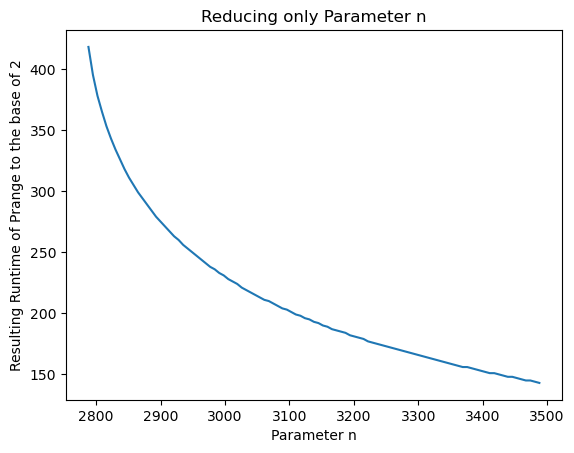

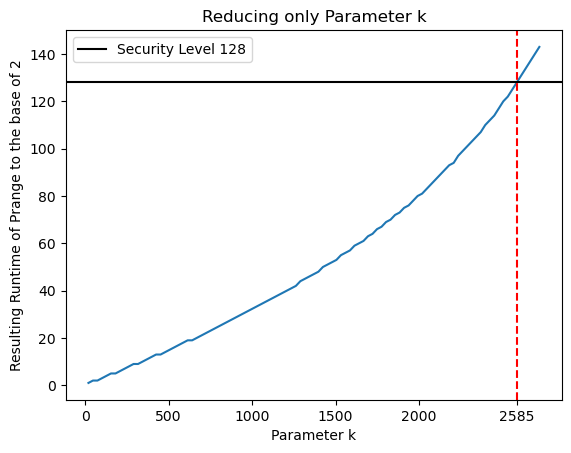

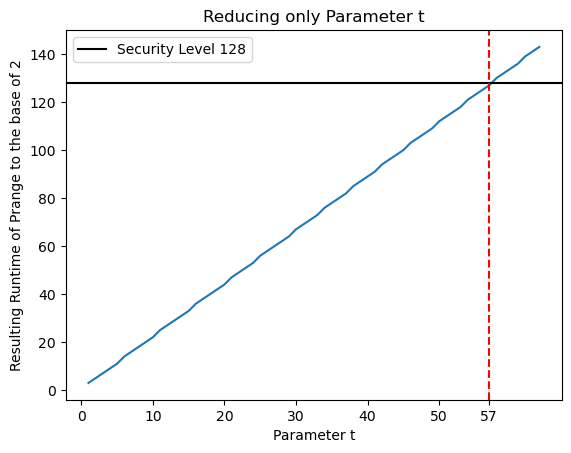

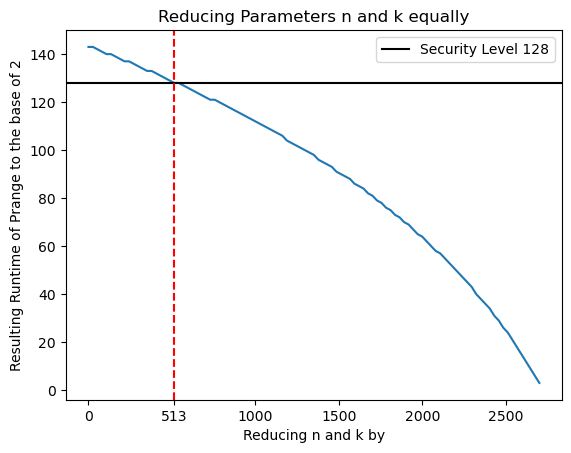

HINT TYPE ONE/TWO:


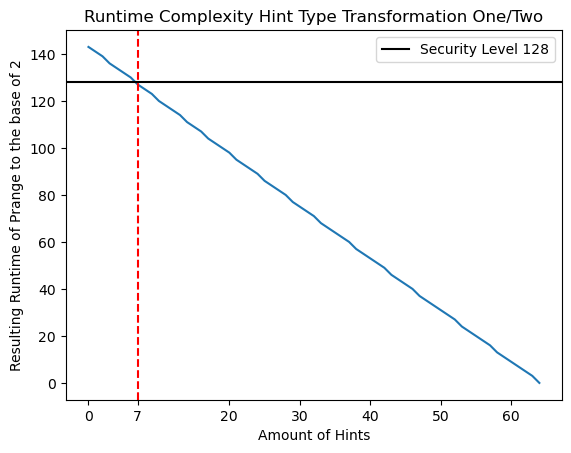

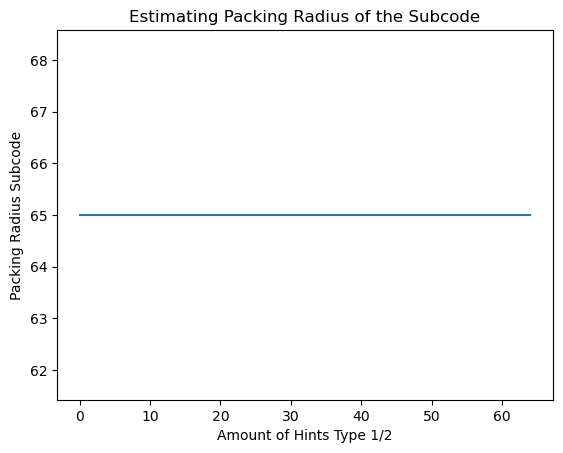

HINT TYPE THREE:


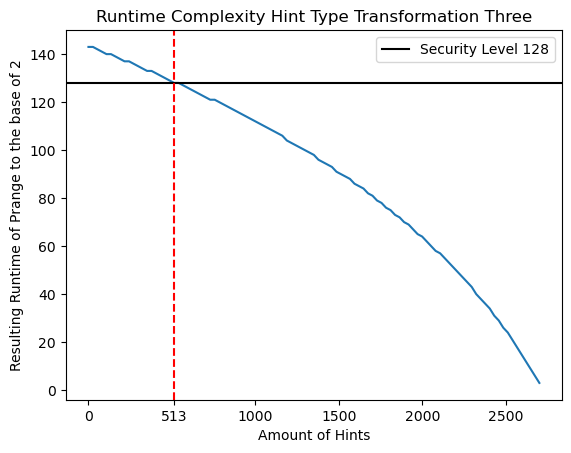

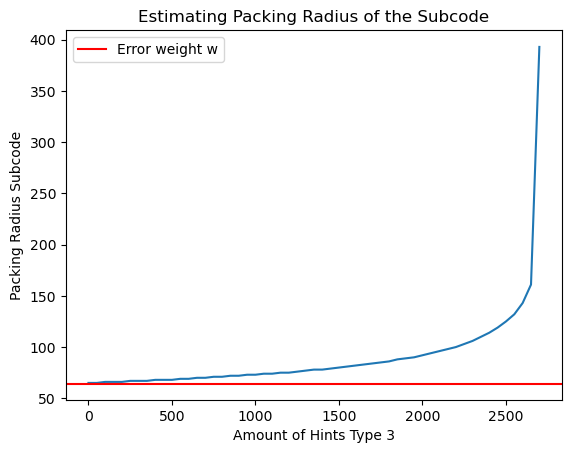

HINT TYPE FOUR/FIVE/SIX:


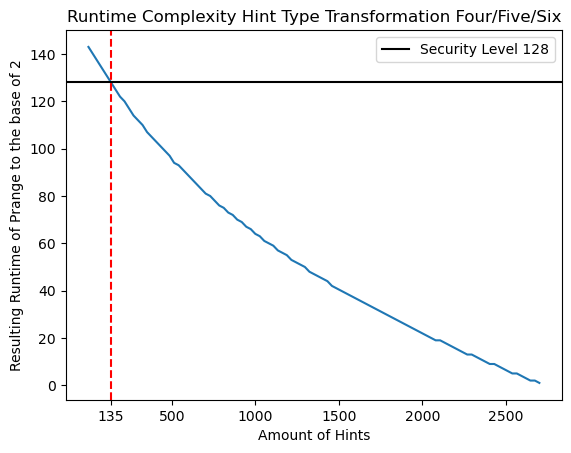

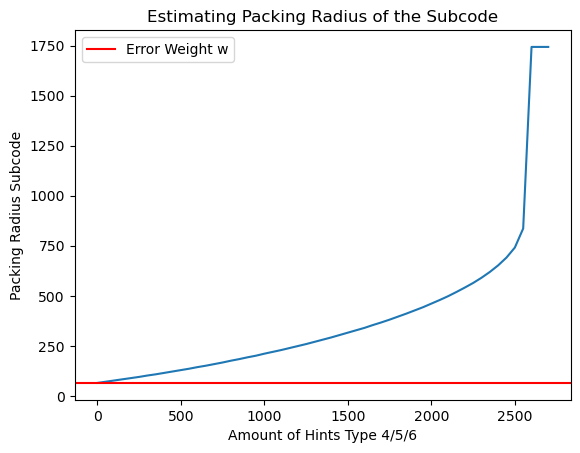

In [13]:
# --- CHANGES IN RUNTIME OF PRANGE (INFOMRATION-SET DECODING ALGORITHMS) --- #

import matplotlib.pyplot as plt
import numpy as np  

# Input: Dimensions n,k and wt_H(e) = w
# Output: Resulting Complexity of Prange when reducing only n
def reducing_only_n(n, k, w):
    x = []
    y = []
    for index in range(0, n-k-w, floor((n-k-w)/100)):
        x.append(n-index)
        y.append(logarithmic_runtime_complexity_prange(int(n-index), k, w))
    
    x = np.array(x)
    y = np.array(y)
    
    plt.plot(x,y)
    plt.xlabel('Parameter n')
    plt.ylabel('Resulting Runtime of Prange to the base of 2')
    plt.title('Reducing only Parameter n')
    plt.show()   

    
# Input: Dimensions n,k and wt_H(e) = w
# Output: Resulting Complexity of Prange when reducing only k    
def reducing_only_k(n, k, w):
    x = []
    y = []
    for index in range(0, k, floor(k/100)):
        x.append(k-index)
        y.append(logarithmic_runtime_complexity_prange(n, int(k-index), w))
    
    x = np.array(x)
    y = np.array(y)
    
    security_level = 0
    for index in range(len(y)):
        if y[-index] <= 128:
            security_level = x[-index]
    
    
    plt.plot(x,y)
    plt.xticks([0, 500, 1000, 1500, 2000, security_level])
    plt.xlabel('Parameter k')
    plt.ylabel('Resulting Runtime of Prange to the base of 2')
    plt.axhline(y=128, color = 'black', linestyle = '-', label='Security Level 128')
    plt.axvline(x=security_level, color = 'r', linestyle = '--')
    plt.title('Reducing only Parameter k')
    plt.legend()
    plt.show()  

    
# Input: Dimensions n,k and wt_H(e) = w
# Output: Resulting Complexity of Prange when reducing only w
def reducing_only_w(n, k, w):
    x = []
    y = []
    for index in range(0, w):
        x.append(w-index)
        y.append(logarithmic_runtime_complexity_prange(n, k, int(w-index)))
    
    x = np.array(x)
    y = np.array(y)
    
    security_level = 0
    for index in range(len(y)):
        if y[-index] <= 128:
            security_level = x[-index]
    
    plt.plot(x,y)
    plt.xticks([0, 10, 20, 30, 40, 50, security_level])
    plt.xlabel('Parameter t')
    plt.ylabel('Resulting Runtime of Prange to the base of 2')
    plt.title('Reducing only Parameter t')
    plt.axhline(y=128, color = 'black', linestyle = '-', label='Security Level 128')
    plt.axvline(x=security_level, color = 'r', linestyle = '--')
    plt.legend()
    plt.show() 


    
# Input: Dimensions n,k and wt_H(e) = w
# Output: Resulting Complexity of Prange when reducing n and k equally
def reducing_n_k_equally(n, k, w):
    x = []
    y = []
    for index in range(0, k, floor(k/100)):
        x.append(index)
        y.append(logarithmic_runtime_complexity_prange(int(n-index), int(k-index), w))
    
    x = np.array(x)
    y = np.array(y)
    
    security_level = 0
    for index in range(len(y)):
        if y[-index] <= 128:
            security_level = x[-index]
    
    
    plt.plot(x,y)
    plt.xticks([0, security_level, 1000, 1500, 2000, 2500])
    plt.xlabel('Reducing n and k by')
    plt.ylabel('Resulting Runtime of Prange to the base of 2')
    plt.axhline(y=128, color = 'black', linestyle = '-', label='Security Level 128')
    plt.axvline(x=security_level, color = 'r', linestyle = '--')
    plt.title('Reducing Parameters n and k equally')
    plt.legend()
    plt.show()  
    
    
    
# Input: Dimensions n,k and wt_H(e) = w
# Output: Resulting Complexity of Prange when using the Hint Type One/Two in the Best Case   
def reducing_hint_type_one_two(n, k, w):    
    x = []
    y = []
    for index in range(0, w+1):
        x.append(index)
        y.append(logarithmic_runtime_complexity_prange(int(n-index), int(k-index), int(w-index)))
    
    x = np.array(x)
    y = np.array(y)
    
    security_level = 0
    for index in range(len(y)):
        if y[index] <= 128:
            security_level = x[index]
            break 
    
    plt.plot(x,y)
    plt.xticks([0, security_level, 20, 30, 40, 50, 60])
    plt.xlabel('Amount of Hints')
    plt.ylabel('Resulting Runtime of Prange to the base of 2')
    plt.axhline(y=128, color = 'black', linestyle = '-', label='Security Level 128')
    plt.axvline(x=security_level, color = 'r', linestyle = '--')
    plt.title('Runtime Complexity Hint Type Transformation One/Two')
    plt.legend()
    plt.show() 
    

    
# Input: Dimensions n, k and the wt_H(e) = w 
# Output: Displaying the Distribution of the Packing Radius
def distribution_approximated_packing_radius_hint_type_one_two(n, k, w):
    x = []
    y = []
    for index in range(0, w+1):
        x.append(index)
        y.append(approximated_packing_radius(n-index, k-index))
    
    x = x[::-1]
    y = y[::-1]
    
    x = np.array(x)
    y = np.array(y)
    plt.plot(x,y)
    plt.title('Estimating Packing Radius of the Subcode')
    plt.xlabel('Amount of Hints Type 1/2')
    plt.ylabel('Packing Radius Subcode')
    plt.show()    
    
    

# Input: Dimensions n,k and wt_H(e) = w
# Output: Resulting Complexity of Prange when using the Hint Type Three in the Best Case   
def reducing_hint_type_three(n, k, w):    
    x = []
    y = []
    for index in range(0, k, floor(k/100)):
        x.append(index)
        y.append(logarithmic_runtime_complexity_prange(int(n-index), int(k-index), w))
    
    x = np.array(x)
    y = np.array(y)
    
    security_level = 0
    for index in range(len(y)):
        if y[index] <= 128:
            security_level = x[index]
            break 
    
    plt.plot(x,y)
    plt.xticks([0, security_level, 1000, 1500, 2000, 2500])
    plt.xlabel('Amount of Hints')
    plt.ylabel('Resulting Runtime of Prange to the base of 2')
    plt.axhline(y=128, color = 'black', linestyle = '-', label='Security Level 128')
    plt.axvline(x=security_level, color = 'r', linestyle = '--')
    plt.title('Runtime Complexity Hint Type Transformation Three')
    plt.legend()
    plt.show() 

    
    
# Input: Dimensions n, k and the wt_H(e) = w 
# Output: Displaying the Distribution of the Packing Radius
def distribution_approximated_packing_radius_hint_type_three(n, k, w):
    x = []
    y = []
    for index in range(0, k+1, 50):
        x.append(index)
        y.append(approximated_packing_radius(n-index, k-index))
    
    x = x[::-1]
    y = y[::-1]
           
    x = np.array(x)
    y = np.array(y)
    plt.plot(x,y)
    plt.axhline(y=w, color = 'r', linestyle = '-', label = "Error weight w")
    plt.title('Estimating Packing Radius of the Subcode')
    plt.xlabel('Amount of Hints Type 3')
    plt.ylabel('Packing Radius Subcode')
    plt.legend()
    plt.show()    
    
    
    
# Input: Dimensions n,k and wt_H(e) = w
# Output: Resulting Complexity of Prange when using the Hint Type Four/Five/Six       
def reducing_hint_type_four_five_six(n, k, w):
    x = []
    y = []
    for index in range(0, k, floor(k/100)):
        x.append(index)
        y.append(logarithmic_runtime_complexity_prange(n, int(k-index), w))
    
    x = np.array(x)
    y = np.array(y)
    
    security_level = 0
    for index in range(len(y)):
        if y[index] <= 128:
            security_level = x[index]
            break 
    
    plt.plot(x,y)
    plt.xticks([security_level, 500, 1000, 1500, 2000, 2500])
    plt.xlabel('Amount of Hints')
    plt.ylabel('Resulting Runtime of Prange to the base of 2')
    plt.axhline(y=128, color = 'black', linestyle = '-', label='Security Level 128')
    plt.axvline(x=security_level, color = 'r', linestyle = '--')
    plt.title('Runtime Complexity Hint Type Transformation Four/Five/Six')
    plt.legend()
    plt.show()  
    

    
# Input: Dimensions n, k and the wt_H(e) = w 
# Output: Displaying the Distribution of the Packing Radius
def distribution_approximated_packing_radius_hint_type_four_five_six(n, k, w):
    x = []
    y = []
    for index in range(0, k+1, 50):
        x.append(index)
        y.append(approximated_packing_radius(n, k-index))
    
    x = x[::-1]
    y = y[::-1]
           
    x = np.array(x)
    y = np.array(y)
    plt.plot(x,y)
    plt.title('Estimating Packing Radius of the Subcode')
    plt.axhline(y = w, color = 'r', linestyle = '-', label='Error Weight w')
    plt.xlabel('Amount of Hints Type 4/5/6')
    plt.ylabel('Packing Radius Subcode')
    plt.legend()
    plt.show()        
    
    
    
# --- USAGE --- #    

n = 3488
k = 2720
w = 64

print("PRELIMINARY OBSERVATIONS:")    
reducing_only_n(n, k, w)
reducing_only_k(n, k, w)
reducing_only_w(n, k, w)
reducing_n_k_equally(n, k, w)

print("HINT TYPE ONE/TWO:")
reducing_hint_type_one_two(n, k, w)
distribution_approximated_packing_radius_hint_type_one_two(n, k, w)

print("HINT TYPE THREE:")
reducing_hint_type_three(n, k, w)
distribution_approximated_packing_radius_hint_type_three(n, k, w)

print("HINT TYPE FOUR/FIVE/SIX:")
reducing_hint_type_four_five_six(n, k, w)
distribution_approximated_packing_radius_hint_type_four_five_six(n, k, w)

In [14]:
# --- IMPLEMENTATION MODIFIED PRANGE WITH --- # 
# --- OPTIMIZATION ALGORITHM (GREEDY ALGORITHM) FOR DECIDING THE OPTIMAL X FOR PRANGE'S ISD --- #

import random

# Input: The Amount of Partitions l, a Partition Array W_i, the cardinalities of the Partitions as Array cardinalities, the Hamming Weight of the blocks as Array t and the calculated Array x 
# Output: Success Probability Modified Prange
def success_probability_modified_prange(l, W_i, cardinalities_W_i, t, x):
    probability = 1
    for index in range(l):
        probability = probability * (binomial(cardinalities_W_i[index] - x[index], t[index]) / binomial(cardinalities_W_i[index], t[index]))
        
    return probability



# Input: The Amount of Partitions l, a Partition Array W_i, the cardinalities of the Partitions as Array cardinalities, the Hamming Weight of the blocks as Array t and the Dimension k 
# Output: Array X with cardinalities of Partitions X_i
def optimization_modified_isd_prange(l, W_i, cardinalities_W_i, t, k):
    x = []
    for index in range(l):
        x.append(cardinalities_W_i[index] - t[index])
        
    in_total = sum(x)
    
    while in_total > k:
        current_lowest = 0
        current_success_probability = None
        
        for index in range(l):
            modified_x = list(x)
            
            if modified_x[index] == 0:
                continue
            
            modified_x[index] = modified_x[index] - 1 
            # When the probability between all x is the same, the first x_i is decreased
            if current_success_probability == None or current_success_probability < success_probability_modified_prange(l, W_i, cardinalities_W_i, t, modified_x):
                current_lowest = index 
                current_success_probability = success_probability_modified_prange(l, W_i, cardinalities_W_i, t, modified_x)
                
        x[current_lowest] = x[current_lowest] - 1
        in_total = in_total - 1 

    return x 



# Input: Generator Matrix G, r = mG + e, the Amount of Partitions l, t = [wt_H(W_1), ...], W_i = [W_1, ... W_l], cardinalities_W_i = [...], Vector X, Dimensions n,k and w(e) = w
# Output: Error e
def modified_isd_prange(G, r, l, t, W_i, cardinalities_W_i, X, n, k, w):
    success = False
    
    while not success:
        united_X = []
        for index in range(l):
            if X[index] == 0:
                continue
                
            sample_X = random.sample(list(W_i[index]), X[index])
            sample_X.sort()   
            for column in sample_X:
                united_X.append(column)

        G_X = G[:, united_X]
        
        if rank(G_X) != k:
            continue
                
        G_X_inverse = G_X.inverse()
        
        r_modified = vector(GF(2), k)
        counter = 0
        for value in united_X:
            r_modified[counter] = r[value]
            counter += 1 
            
        G_new = G_X_inverse * G
        calculated_e = r + r_modified * G_new
                
        if calculated_e.hamming_weight() == w:
            return calculated_e
        

        
        
# --- USAGE --- #
n = 237
k = 124
w = int(approximated_packing_radius(n,k)/2)
P, G, s, r, e, m = generate_syndrome_decoding_problem(n, k, w)

amount_partitions = 7    
t, W_i, cardinalities_W_i = hint_hamming_weight(e, n, [], amount_partitions, True) 
X = optimization_modified_isd_prange(amount_partitions, W_i, cardinalities_W_i, t, k)

calculated_e = modified_isd_prange(G, r, amount_partitions, t, W_i, cardinalities_W_i, X, n, k, w)
print("OUR PARTITIONS HAVE THE CARDINALITIES OF: cardinalities_W_i =", cardinalities_W_i)
print("THE PARTITIONS HAVE FOLLOWING HAMMING WEIGHT: t =", t)
print("THE PARAMETER X LOOKS AS FOLLOWS: X =", X)
if e == calculated_e:
    print(">> MODIFIED PRIMAL PRANGE WAS SUCCESSFUL!")

print("\n--- NOW FOR NOT EQUAL SIZED PARTITIONS ---\n")    
partitions = create_random_partition(amount_partitions, n)
t, W_i, cardinalities_W_i = hint_hamming_weight(e, n, partitions, amount_partitions, False)
X = optimization_modified_isd_prange(amount_partitions, W_i, cardinalities_W_i, t, k)

calculated_e = modified_isd_prange(G, r, amount_partitions, t, W_i, cardinalities_W_i, X, n, k, w)
print("OUR PARTITIONS HAVE THE CARDINALITIES OF: cardinalities_W_i =", cardinalities_W_i)
print("THE PARTITIONS HAVE FOLLOWING HAMMING WEIGHT: t =", t)
print("THE PARAMETER X LOOKS AS FOLLOWS: X =", X)
if e == calculated_e:
    print(">> MODIFIED PRIMAL PRANGE WAS SUCCESSFUL!")

OUR PARTITIONS HAVE THE CARDINALITIES OF: cardinalities_W_i = [34, 34, 34, 34, 34, 34, 33]
THE PARTITIONS HAVE FOLLOWING HAMMING WEIGHT: t = [1, 0, 1, 0, 1, 1, 2]
THE PARAMETER X LOOKS AS FOLLOWS: X = [14, 34, 14, 34, 14, 14, 0]
>> MODIFIED PRIMAL PRANGE WAS SUCCESSFUL!

--- NOW FOR NOT EQUAL SIZED PARTITIONS ---



OUR PARTITIONS HAVE THE CARDINALITIES OF: cardinalities_W_i = [39, 13, 24, 78, 55, 27, 1]
THE PARTITIONS HAVE FOLLOWING HAMMING WEIGHT: t = [1, 0, 0, 1, 3, 1, 0]
THE PARAMETER X LOOKS AS FOLLOWS: X = [19, 13, 24, 59, 0, 8, 1]
>> MODIFIED PRIMAL PRANGE WAS SUCCESSFUL!


In [15]:
# --- IMPLEMENTAION MODIFIED LEE-BRICKELL ISD WITH --- # 
# --- OPTIMIZATION ALGORITHM (GREEDY ALGORITHM) FOR DECIDING THE OPTIMAL X,Y AND Z FOR LEE-BRICKELL'S ISD --- #

import random 

# Input: The Amount of Partitions l, a Partition Array W_i, the cardinalities of the Partitions as Array cardinalities, the Hamming Weight of the blocks as Array t, 
#        the calculated Array x and the amount of errors outside the information set notated with p
# Output: Success Probability Modified Lee-Brickell and None when the Probability is not defined  
def success_probability_modified_lee_brickell(l, W_i, cardinalities_W_i, t, x, p):
    if p == 0:
        return success_probability_modified_prange(l, W_i, cardinalities_W_i, t, x)
     
    possible_a = all_possible_sums(p, l)
    probability = 0
    for a in possible_a:
        current_probability = 1
        for index in range(l):
            if x[index] == 0:
                return
            
            numerator = binomial(x[index], int(a[index])) * binomial(cardinalities_W_i[index] - x[index], t[index] - int(a[index]))
            denominator = binomial(cardinalities_W_i[index], t[index])
            
            if numerator != 0 and denominator != 0:
                current_probability = current_probability * (numerator / denominator) 
           
        probability += current_probability
   
    return probability



# Input: The Amount of Partitions l, a Partition Array W_i, the cardinalities of the Partitions as Array cardinalities, the Hamming Weight of the blocks as Array t,
#        the Dimension k and the amount of errors outside the information set notated with p 
# Output: Array X with cardinalities of Partitions X_i
def optimization_modified_isd_lee_brickell(l, W_i, cardinalities_W_i, t, k, p):
    x = []
    for index in range(l):
        x.append(cardinalities_W_i[index] - t[index])
        
    in_total = sum(x)
    
    while in_total > k:
        current_lowest = 0
        current_success_probability = None
        
        for index in range(l):
            modified_x = list(x)
            
            if modified_x[index] == 0:
                continue
            
            modified_x[index] = modified_x[index] - 1 
            # When the probability between all x is the same, the first x_i is decreased
            success = success_probability_modified_lee_brickell(l, W_i, cardinalities_W_i, t, modified_x, p)
            if success == None:
                continue
            
            if current_success_probability == None or current_success_probability < success:
                current_lowest = index 
                current_success_probability = success

                
        if x[current_lowest] != 0:
            x[current_lowest] = x[current_lowest] - 1
        # Edge Case: All x_i have the same probability!
        else:
            while True:
                index = random.randint(0,l-1)
                if index != current_lowest and x[index] != 0:
                    x[index] = x[index] - 1
                    break
            
        in_total = in_total - 1 

    return x 



# Input: Generator Matrix G, r = mG + e, the Amount of Partitions l, t = [wt_H(W_1), ...], W_i = [W_1, ... W_l], cardinalities_W_i = [...], Vector X, Dimensions n,k 
#        w(e) = w and p the amount of errors outside the information set 
# Output: Error e
def modified_isd_lee_brickell(G, r, l, t, W_i, cardinalities_W_i, X, n, k, w, p, optimal):
    if p > w:
        return "p has to be smaller or equal w!"

    if optimal:
        p = 0 
        
    success = False
    while not success:
        # Pre-Computations 
        united_X = []
        for index in range(l):
            if X[index] == 0:
                continue
                
            sample_X = random.sample(list(W_i[index]), X[index])
            sample_X.sort()   
            for column in sample_X:
                united_X.append(column)

        G_X = G[:, united_X]
        
        if rank(G_X) != k:
            continue
                
        G_X_inverse = G_X.inverse()
        
        r_modified = vector(GF(2), k)
        counter = 0
        for value in united_X:
            r_modified[counter] = r[value]
            counter += 1 
            
        G_new = G_X_inverse * G
        e_I = r + r_modified * G_new
                
        # Second Step
        if p == 0:
            if e_I.hamming_weight() == w:
                return e_I
        
        epsilons = unique_permutations(k, p)
        for candidate in epsilons:
            e_I_modified = e_I + candidate * G_new
            if e_I_modified.hamming_weight() == w:
                return e_I_modified
            

            
            
# --- USAGE --- #
n = 237
k = 124
w = int(approximated_packing_radius(n,k)/2)
P, G, s, r, e, m = generate_syndrome_decoding_problem(n, k, w)
  
p = 1
amount_partitions = 7 
t, W_i, cardinalities_W_i = hint_hamming_weight(e, n, [], amount_partitions, True) 
X = optimization_modified_isd_lee_brickell(amount_partitions, W_i, cardinalities_W_i, t, k, p)

print("THE OPTIMAL VALUE FOR THE PARAMETER P IS 0!")
print("DISCLAMER: CALCULATING THE OPTIMIZED X IS VERY COSTLY!\n")

print("OUR PARTITIONS HAVE THE CARDINALITIES OF: cardinalities_W_i =", cardinalities_W_i)
print("THE PARTITIONS HAVE FOLLOWING HAMMING WEIGHT: t =", t)
print("THE PARAMETER X LOOKS AS FOLLOWS: X =", X)
calculated_e = modified_isd_lee_brickell(G, r, amount_partitions, t, W_i, cardinalities_W_i, X, n, k, w, p, False)
if e == calculated_e:
    print(">> MODIFIED PRIMAL LEE-BRICKELL WAS SUCCESFUL!")

    
print("\n--- NOW FOR NOT EQUAL SIZED PARTITIONS ---\n")    
partitions = create_random_partition(amount_partitions, n)
t, W_i, cardinalities_W_i = hint_hamming_weight(e, n, partitions, amount_partitions, False)
X = optimization_modified_isd_lee_brickell(amount_partitions, W_i, cardinalities_W_i, t, k, p)

calculated_e = modified_isd_lee_brickell(G, r, amount_partitions, t, W_i, cardinalities_W_i, X, n, k, w, p, False)

print("OUR PARTITIONS HAVE THE CARDINALITIES OF: cardinalities_W_i =", cardinalities_W_i)
print("THE PARTITIONS HAVE FOLLOWING HAMMING WEIGHT: t =", t)
print("THE PARAMETER X LOOKS AS FOLLOWS: X =", X)
if e == calculated_e:
    print(">> MODIFIED PRIMAL LEE-BRICKELL WAS SUCCESFUL!")

THE OPTIMAL VALUE FOR THE PARAMETER P IS 0!
DISCLAMER: CALCULATING THE OPTIMIZED X IS VERY COSTLY!

OUR PARTITIONS HAVE THE CARDINALITIES OF: cardinalities_W_i = [34, 34, 34, 34, 34, 34, 33]
THE PARTITIONS HAVE FOLLOWING HAMMING WEIGHT: t = [1, 0, 0, 0, 0, 2, 3]
THE PARAMETER X LOOKS AS FOLLOWS: X = [1, 19, 34, 34, 34, 1, 1]


>> MODIFIED PRIMAL LEE-BRICKELL WAS SUCCESFUL!

--- NOW FOR NOT EQUAL SIZED PARTITIONS ---



OUR PARTITIONS HAVE THE CARDINALITIES OF: cardinalities_W_i = [33, 1, 131, 1, 1, 4, 66]
THE PARTITIONS HAVE FOLLOWING HAMMING WEIGHT: t = [1, 0, 0, 0, 0, 0, 5]
THE PARAMETER X LOOKS AS FOLLOWS: X = [1, 1, 115, 1, 1, 4, 1]
>> MODIFIED PRIMAL LEE-BRICKELL WAS SUCCESFUL!


In [16]:
# --- IMPLEMENTAION MODIFIED DUMER-STERN ISD WITH --- # 
# --- OPTIMIZATION ALGORITHM (GREEDY ALGORITHM) FOR DECIDING THE OPTIMAL X,Y AND Z FOR DUMER-STERN'S ISD --- #

import random
from collections import defaultdict
from itertools import chain

# Input: The Amount of Partitions l, a Partition Array W_i, the cardinalities of the Partitions as Array cardinalities, the Hamming Weight of the blocks as Array t, 
#        the calculated Array x,y and z and half of the amount of errors outside the information set notated with p
# Output: Success Probability Modified Stern and None when the Probability is not defined
def success_probability_modified_stern(l, W_i, cardinalities_W_i, t, x, y, z, p):
    if p == 0:
        return success_probability_modified_prange(l, W_i, cardinalities_W_i, t, x)
    
    possible_a = all_possible_sums(p, l)
    possible_b = all_possible_sums(p, l)
    probability = 0
    for a in possible_a:
        current_probability = 1
        for b in possible_b:
            for index in range(l):
                numerator = binomial(x[index], int(a[index])) * binomial(y[index], int(b[index])) 
                numerator *= binomial(cardinalities_W_i[index] - x[index] - y[index] - z[index] ,t[index] - int(a[index]) - int(b[index]))
                denominator = binomial(cardinalities_W_i[index], t[index])
                if numerator != 0 and denominator != 0:
                    current_probability = current_probability * (numerator / denominator) 
                
            probability += current_probability

    return probability



# Input: The Amount of Partitions l, a Partition Array W_i, the cardinalities of the Partitions as Array cardinalities, the Hamming Weight of the blocks as Array t,
#        the Dimension k, the amount of errors outside the information set notated with p and the switch flag to determine whether x is set through the
#        Prange Optimization or through the Lee-Brickell Optimization
# Output: Array X, Y and Z with cardinalities of Partitions X_i, Y_i and Z_i
def optimization_modified_isd_stern(l, W_i, cardinalities_W_i, t, k, p, v, switch):
    if v > n - k:
        return "v has to be smaller than n-k!"
    
    if switch:
        x_tilde = optimization_modified_isd_lee_brickell(l, W_i, cardinalities_W_i, t, k, int(2*p))
    else:
        x_tilde = optimization_modified_isd_prange(l, W_i, cardinalities_W_i, t, k)
        
    x = []
    y = []
    round_x_up = True
    
    for element in x_tilde:
        if element % 2 == 0:
            x.append(int(element/2))
            y.append(int(element/2))
        else:
            if round_x_up:
                x.append(ceil(element/2))
                y.append(floor(element/2))
                round_x_up = False
            else:
                x.append(floor(element/2))
                y.append(ceil(element/2))
                round_x_up = True
                
    z = [0] * l
    while sum(z) < v:
        current_highest = 0
        current_success_probability = None
        
        for index in range(l):
            if cardinalities_W_i[index] == x[index] + y[index] + z[index]:
                continue
            
            modified_z = list(z)
            modified_z[index] += 1 
            success = success_probability_modified_stern(l, W_i, cardinalities_W_i, t, x, y, z, p)
            if success == None:
                continue
            
            if current_success_probability == None or current_success_probability < success:
                current_highest = index
                current_success_probability = success
                
        z[current_highest] += 1
        
    return x, y, z
            
    
    
# Input: Generator Matrix G, r = mG + e, the Amount of Partitions l, t = [wt_H(W_1), ...], W_i = [W_1, ... W_l], cardinalities_W_i = [...], Vector X, Y and Z, Dimensions n,k 
#        w(e) = w, p the amount of errors inside the information set, v and the optimal flag for optimized v and p 
# Output: Error e
def modified_isd_stern(G, r, l, t, W_i, cardinalities_W_i, X, Y, Z, n, k, w, p, v, optimal):
    if optimal:
        v, p = optimal_runtime_complexity_isd_stern(n, k, w)
    
    success = False
    while not success:
        # Precomputations, compute X, Y and Z 
        united_X = []
        united_Y = []
        united_Z = []
        for index in range(l):
            W_without_X = list(W_i[index])
            W_without_X_Y = list(W_i[index])
            
            if X[index] != 0:
                sample_X = sorted(random.sample(list(W_i[index]), X[index]))
                sample_X.sort()   
                for column in sample_X:
                    united_X.append(column)
                    
                W_without_X = list(filter(lambda a: a not in sample_X, W_i[index]))
                    
            if Y[index] != 0:
                sample_Y = sorted(random.sample(W_without_X, Y[index]))
                for column in sample_Y:
                    united_Y.append(column)
                    
                W_without_X_Y = list(filter(lambda a: a not in sample_Y, W_without_X))
                
            if Z[index] != 0:
                sample_Z = sorted(random.sample(W_without_X_Y, Z[index]))
                for column in sample_Z:
                    united_Z.append(column)
        
        I = sorted(united_X + united_Y)
    
        if G[:, I].rank() != k:
            continue 
            
        r_I = vector(GF(2), k)
        counter = 0
        for value in I:
            r_I[counter] = r[value]
            counter += 1 
            
        G_new = G[:, I].inverse() * G
        r_modified = r + r_I * G_new    
        
        values_A = []
        values_B = []
        
        counter = 0
        for element in I:
            if element in united_X:
                values_A.append(counter)
            else:
                values_B.append(counter)
            counter += 1
        
        phi_A = defaultdict(list)
        for current_vector in unique_combinations(values_A, k, p):
            value_phi_A = []
            result = r_modified + current_vector * G_new
            for index in Z:
                value_phi_A.append(result[index])
            phi_A[repr(value_phi_A)].append(current_vector * G_new)
        
        for candidate in unique_combinations(values_B, k, p):
            result = candidate * G_new
            value_psi_B = []
            for index in Z:
                value_psi_B.append(result[index])
            
            for sum_phi_A in phi_A[repr(value_psi_B)]:
                e = r_modified + sum_phi_A + result
                if e.hamming_weight() == w:
                    return e 

                
                

# --- USAGE --- #                 
n = 237
k = 124
w = int(approximated_packing_radius(n,k)/2)
P, G, s, r, e, m = generate_syndrome_decoding_problem(n, k, w)

amount_of_partitions = 7
v, p = optimal_runtime_complexity_isd_stern(n, k, w)
print("THE OPTIMAL VALUES FOR THE PARAMETERS V AND P ARE: V =", v, "and P =", p)
print("DISCLAMER: WHEN USING THE LEE-BRICKELL OPTIMIZATION CALCULATING THE OPTIMIZED X, Y, Z IS VERY COSTLY!\n")

t, W_i, cardinalities_W_i = hint_hamming_weight(e, n, [], amount_of_partitions, True)
X, Y, Z = optimization_modified_isd_stern(amount_of_partitions, W_i, cardinalities_W_i, t, k, p, v, True)
X_p, Y_p, Z_p = optimization_modified_isd_stern(amount_of_partitions, W_i, cardinalities_W_i, t, k, p, v, False)

calculated_e = modified_isd_stern(G, r, amount_of_partitions, t, W_i, cardinalities_W_i, X, Y, Z, n, k, w, p, v, False)    
print("\nOUR PARTITIONS HAVE THE CARDINALITIES OF: cardinalities_W_i =", cardinalities_W_i)
print("THE PARTITIONS HAVE FOLLOWING HAMMING WEIGHT: t =", t)
print("THE PARAMETERS LOOK AS FOLLOWS (LEE-BRICKELL): \nX =", X, "\nY =", Y, "\nZ =", Z, "\nv =", v, "\np =", p)
print("\nTHE PARAMETERS LOOK AS FOLLOWS (PRANGE): \nX =", X_p, "\nY =", Y_p, "\nZ =", Z_p)

if calculated_e == e:
    print(">> THE MODIFIED ISD STERN WAS SUCCESFUL!")   
    
print("\n--- NOW FOR NOT EQUAL SIZED PARTITIONS ---\n")    
partitions = create_random_partition(amount_of_partitions, n)
t, W_i, cardinalities_W_i = hint_hamming_weight(e, n, partitions, amount_of_partitions, False)
X, Y, Z = optimization_modified_isd_stern(amount_of_partitions, W_i, cardinalities_W_i, t, k, p, v, False)
X_lee, Y_lee, Z_lee = optimization_modified_isd_stern(amount_of_partitions, W_i, cardinalities_W_i, t, k, p, v, True)

calculated_e = modified_isd_stern(G, r, amount_of_partitions, t, W_i, cardinalities_W_i, X, Y, Z, n, k, w, p, v, False)    
print("OUR PARTITIONS HAVE THE CARDINALITIES OF: cardinalities_W_i =", cardinalities_W_i)
print("THE PARTITIONS HAVE FOLLOWING HAMMING WEIGHT: t =", t)
print("THE PARAMETERS LOOK AS FOLLOWS (PRANGE): \nX =", X, "\nY =", Y, "\nZ =", Z)

if calculated_e == e:
    print(">> THE MODIFIED ISD STERN WAS SUCCESFUL!")  
    
print("\nIF Z IS ZERO EVERYWHERE THE PROBABILITY IS THE SAME FOR ALL FREE LOCATIONS. AFTER THE INCREMENT THE INCREMENTED SPOT INCREASES THE PROBABILITY THE MOST!")    

THE OPTIMAL VALUES FOR THE PARAMETERS V AND P ARE: V = 12 and P = 1
DISCLAMER: WHEN USING THE LEE-BRICKELL OPTIMIZATION CALCULATING THE OPTIMIZED X, Y, Z IS VERY COSTLY!




OUR PARTITIONS HAVE THE CARDINALITIES OF: cardinalities_W_i = [34, 34, 34, 34, 34, 34, 33]
THE PARTITIONS HAVE FOLLOWING HAMMING WEIGHT: t = [0, 1, 2, 0, 1, 0, 2]
THE PARAMETERS LOOK AS FOLLOWS (LEE-BRICKELL): 
X = [17, 10, 0, 17, 1, 17, 0] 
Y = [17, 9, 1, 17, 0, 17, 1] 
Z = [0, 12, 0, 0, 0, 0, 0] 
v = 12 
p = 1

THE PARAMETERS LOOK AS FOLLOWS (PRANGE): 
X = [17, 6, 0, 17, 5, 17, 0] 
Y = [17, 5, 0, 17, 6, 17, 0] 
Z = [0, 12, 0, 0, 0, 0, 0]
>> THE MODIFIED ISD STERN WAS SUCCESFUL!

--- NOW FOR NOT EQUAL SIZED PARTITIONS ---



OUR PARTITIONS HAVE THE CARDINALITIES OF: cardinalities_W_i = [50, 1, 91, 92, 1, 1, 1]
THE PARTITIONS HAVE FOLLOWING HAMMING WEIGHT: t = [0, 0, 3, 3, 0, 0, 0]
THE PARAMETERS LOOK AS FOLLOWS (PRANGE): 
X = [25, 1, 17, 18, 0, 1, 0] 
Y = [25, 0, 17, 18, 1, 0, 1] 
Z = [0, 0, 12, 0, 0, 0, 0]
>> THE MODIFIED ISD STERN WAS SUCCESFUL!

IF Z IS ZERO EVERYWHERE THE PROBABILITY IS THE SAME FOR ALL FREE LOCATIONS. AFTER THE INCREMENT THE INCREMENTED SPOT INCREASES THE PROBABILITY THE MOST!


In [17]:
# --- OPTIMIZATION TRANSFORMATION HINT TYPE SIX FOR PROCESSING MULTIPLE HINTS AT ONCE --- #

# Input: (n,k,w)-SDP defined through Generator Matrix G, r = mG+e and amount_of_hints measurement vectors v_i ϵ GF(2)^k\{0}  
#         with sigma = m * v^t mod 2 saved in sigmas = [[v_1, sigma_1], [v_2, sigma_2], ...]
# Output: (n, k-X, w)-SDP defined through Parity-Check Matrix P_new and Syndrome s_new
def optimization_transformation_hint_type_six(G, r, sigmas, amount_of_hints, n, k, w):
    if amount_of_hints == 1:
        return transformation_hint_type_six(G, r, sigmas, amount_of_hints, n, k, w)
    
    hint_matrix = matrix(GF(2), k+1, amount_of_hints)
    
    for column in range(amount_of_hints):
        new_entry = list(sigmas[column][0])
        new_entry.append(sigmas[column][1])
        new_entry = vector(GF(2), new_entry)
        hint_matrix[:, column] = new_entry
        
    if rank(hint_matrix) != amount_of_hints:
        return "The Hint Vectors have to be linearly independent!"
    
    V = hint_matrix[:len(sigmas[0][0]), :] 
    Sigma = hint_matrix[len(sigmas[0][0]):, :]
    
    V_1 = V[:amount_of_hints, :]
    
    if rank(V_1) != amount_of_hints:
        return "V_1 is not invertable!"
    
    left_matrix_part = hint_matrix * V_1.inverse()
    
    right_matrix_part = matrix(GF(2), k+1, n)
    
    for column in range(n):
        new_entry = []
        for row in range(G.nrows()):
            new_entry.append(G[row, column])
            
        new_entry.append(r[column])
        new_entry = vector(GF(2), new_entry)
        right_matrix_part[:, column] = new_entry
        
    resulting_matrix = left_matrix_part.augment(right_matrix_part)
    
    for column in range(amount_of_hints, resulting_matrix.ncols()):
        for row in range(0, amount_of_hints):
            if resulting_matrix[row, column] == 1:
                resulting_matrix[:, column] += resulting_matrix[:, row]
        
    right_part = resulting_matrix[:, amount_of_hints:]
    G_new = right_part[amount_of_hints:k , :]
    last_row = right_part[k: , :]
    r_new = vector(GF(2), n)
    for index in range(n):
        r_new[index] = last_row[0][index]
    
    k_new = G_new.nrows()
    n_new = G_new.ncols()
    w_new = w 
    
    P_new = from_generator_to_parity_check(G_new)
    s_new = P_new * r_new 
    
    return P_new, s_new, n_new, k_new, w_new




# --- USAGE --- # 
n = 237
k = 124
w = int(approximated_packing_radius(n,k)/2)
P, G, s, r, e, m = generate_syndrome_decoding_problem(n, k, w)

print("FOR SIMPLICITY REASONS THIS TRANSFORMATION ONLY WORKS WHEN THE MATRIX V_1 IS INVERTABLE!")
amount_of_hints = 3
v = generate_linearly_independent_v(k, amount_of_hints) 
sigmas = hint_type_six(k, v, m, amount_of_hints) 
    
try:
    P_new, s_new, n_new, k_new, w_new = optimization_transformation_hint_type_six(G, r, sigmas, amount_of_hints, n, k, w)
    print("\nTHE TEST INSTANCE HAS PARAMETERS: N =", n, "K =", k, "w =", w)
    print("AFTER THE TRANSFORMATION NEW PARAMETERS ARE: N =", n_new, "K =", k_new, "w =", w_new) 
except:
    print("PLEASE TRY IT AGAIN!")

FOR SIMPLICITY REASONS THIS TRANSFORMATION ONLY WORKS WHEN THE MATRIX V_1 IS INVERTABLE!
PLEASE TRY IT AGAIN!


THE TRANSFORMATION ASSUMES, THAT THE DELETED POSITIONS OF E ARE ALL ERROR-FREE, SO THE INJECTION POINTS HAS TO BE ERROR-FREE.
FURTHERMORE THIS TRANSFORMATION ASSUMES, THAT DECODING IS STILL UNIQUE IN THE NEW INSTANCE FOR THE WEIGHT W!

SUCCESS RATE OF THE ATTEMPT IN A MCELIECE SETTING:


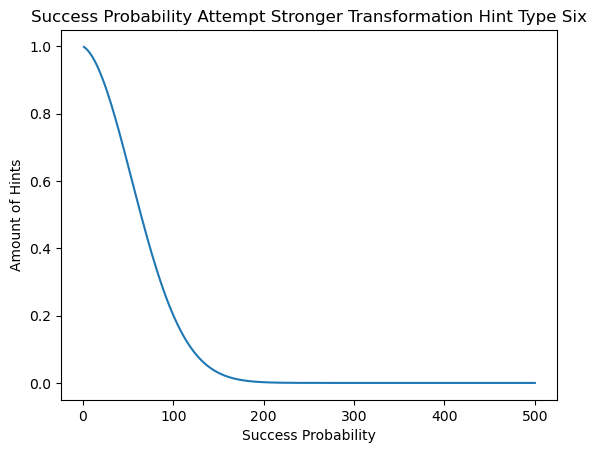


SUCCESS RATE OF THE ATTEMPT IN THE CURRENT SETTING:


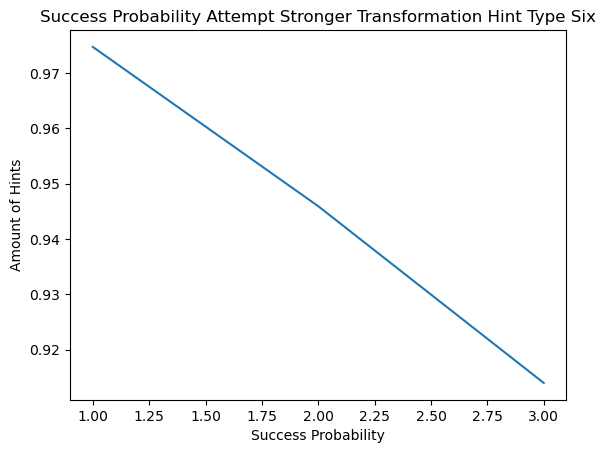


THE TEST INSTANCE HAS PARAMETERS: N = 237 K = 124 w = 6
AFTER THE TRANSFORMATION NEW PARAMETERS ARE: N = 234 K = 121 w = 6
BY ASSUMING THAT DECODING IS STILL UNIQUE FOR A ERROR WEIGHT OF W WE CAN OPTIMIZE THE TRANSFORMATION BY INTRODUCING A MODIFIED PRANGE: 

def modified_isd_primal_prange(G, r, n, k, w):
    success = False
    
    while not success:
        I = sorted(random.sample(list(range(n)), k))
    
        if G[:, I].rank() != k:
            continue 

        G_I = G[:, I]
        G_I_inverse = G_I.inverse()
        
        r_modified = vector(GF(Integer(2)), k)
        counter = Integer(0)
        for value in I:
            r_modified[counter] = r[value]
            counter += Integer(1) 
            
        G_new = G_I_inverse * G
        calculated_e = r + r_modified * G_new
                
        if calculated_e.hamming_weight() <= w:
            return r_modified * G_I_inverse   


THIS ALGORITHM IS STILL CORRECT SINCE DECODING IS UNIQUE FOR ERROR VECTORS OF HAMM

In [18]:
# --- ATTEMPT FOR A STRONGER TRANSFORMATION THROUGH MULTIPLE HINTS OF HINT TYPE SIX --- # 
# NOTE: This Transformation is also only possible if in the smaller instance decoding with the weight of w is unique.
#       >> Otherwise if the Transformation is successful and the Decoding is not unique, we have to use List Decoding!

import numpy as np 
import copy
import random  
import inspect
from matplotlib import pyplot as plt

# Input: (n,k,w)-SDP defined through Generator Matrix G, r = mG+e and amount_of_hints measurement vectors v_i ϵ GF(2)^k\{0}  
#         with sigma = m * v^t mod 2 saved in sigmas = [[v_1, sigma_1], [v_2, sigma_2], ...]
# Output: (n-X, k-Y, w)-SDP defined through Parity-Check Matrix P_new, Syndrome s_new and a Array sigmas, that contains error-free and error locations
def attempt_optimization_transformation_hint_type_six(G, r, sigmas, amount_of_hints, n, k, w):
    injection_points = random.sample(list(np.arange(n)), amount_of_hints) 
    G_new = copy.copy(G) 
    r_new = r
    w_new = w
    new_sigmas = []
    
    # Calculating the modified SDP-Instance with known error and error-free location
    # Here is the assumption, that the error is always error-free in the injection points 
    # >> The gained weight 
    counter = 0
    for index in injection_points:
        G_new[:, index] = sigmas[counter][0]
        r_new[index] = 0
        new_sigmas.append([index, sigmas[counter][1]])
        if sigmas[counter][1] == 1:
            w_new += 1 
            
        counter += 1
        
    P_new = from_generator_to_parity_check(G_new)
    s_new = P_new * r_new 
    
    # Using the error and error-free locations to create a much smaller SDP-Instance
    for index in range(len(new_sigmas)):
        if new_sigmas[index][1] == 0:
            P_new, s_new, n_new, k_new, w_new = transformation_hint_type_three(P_new, s_new, [new_sigmas[index][0]], 1, P_new.ncols(), P_new.ncols() -P_new.nrows(), w_new)
        if new_sigmas[index][1] == 1:
            P_new, s_new, n_new, k_new, w_new = transformation_hint_type_one_two(P_new, s_new, [new_sigmas[index][0]], 1, P_new.ncols(), P_new.ncols() - P_new.nrows(), w_new)
        
    return P_new, s_new, n_new, k_new, w_new



# Input: n, w = wt_H(e) and the amount_of_hints
# Output: Success Probability of the Optimization Attempt
def success_probability_attempt_hint_type_six(n, w, amount_of_hints):
    success_probability = 1 
    for index in range(0, amount_of_hints):
        success_probability = success_probability * ((n-w-index) / n) 
        
    return float(success_probability)



# Input: n, w = wt_H(e) and the amount_of_hints
# Output: Displays the Success Probability of the Transformation when using x Hints, where 1 <= x <= amount_of_hints
def distribution_success_probability_attempt(n, w, amount_of_hints):
    x = []
    y = []
    for index in range(1, amount_of_hints+1):
        x.append(index)
        y.append(success_probability_attempt_hint_type_six(n, w, index))
        
    x = np.array(x)
    y = np.array(y)
    plt.plot(x, y)
    plt.title('Success Probability Attempt Stronger Transformation Hint Type Six')
    plt.xlabel('Success Probability')
    plt.ylabel('Amount of Hints')
    plt.show()

    
    
# Input: Generator Matrix G, Errornous Codeword r = mG + e, Dimensions n,k and w(e)<= w 
# Output: Error e
def modified_isd_primal_prange(G, r, n, k, w):
    success = False
    
    while not success:
        I = sorted(random.sample(list(range(n)), k))
    
        if G[:, I].rank() != k:
            continue 

        G_I = G[:, I]
        G_I_inverse = G_I.inverse()
        
        r_modified = vector(GF(2), k)
        counter = 0
        for value in I:
            r_modified[counter] = r[value]
            counter += 1 
            
        G_new = G_I_inverse * G
        calculated_e = r + r_modified * G_new
                
        if calculated_e.hamming_weight() <= w:
            return r_modified * G_I_inverse   
    
    
    
    
# --- USAGE --- # 
n = 3488
k = 2720
amount_of_hints = 500

print("THE TRANSFORMATION ASSUMES, THAT THE DELETED POSITIONS OF E ARE ALL ERROR-FREE, SO THE INJECTION POINTS HAS TO BE ERROR-FREE.")
print("FURTHERMORE THIS TRANSFORMATION ASSUMES, THAT DECODING IS STILL UNIQUE IN THE NEW INSTANCE FOR THE WEIGHT W!\n")
print("SUCCESS RATE OF THE ATTEMPT IN A MCELIECE SETTING:")
distribution_success_probability_attempt(n, w, amount_of_hints)

n = 237
k = 124
amount_of_hints = 3 
w = int(approximated_packing_radius(n,k)/2)

print("\nSUCCESS RATE OF THE ATTEMPT IN THE CURRENT SETTING:")
distribution_success_probability_attempt(n, w, amount_of_hints)

P, G, s, r, e, m = generate_syndrome_decoding_problem(n, k, w)

v = generate_linearly_independent_v(k, amount_of_hints) 
sigmas = hint_type_six(k, v, m, amount_of_hints) 
P_new, s_new, n_new, k_new, w_new = attempt_optimization_transformation_hint_type_six(G, r, sigmas, amount_of_hints, n, k, w)
print("\nTHE TEST INSTANCE HAS PARAMETERS: N =", n, "K =", k, "w =", w)
print("AFTER THE TRANSFORMATION NEW PARAMETERS ARE: N =", n_new, "K =", k_new, "w =", w_new)

print("BY ASSUMING THAT DECODING IS STILL UNIQUE FOR A ERROR WEIGHT OF W WE CAN OPTIMIZE THE TRANSFORMATION BY INTRODUCING A MODIFIED PRANGE: \n")

code, line_no = inspect.getsourcelines(modified_isd_primal_prange)
print(''.join(code))

print("\nTHIS ALGORITHM IS STILL CORRECT SINCE DECODING IS UNIQUE FOR ERROR VECTORS OF HAMMING WEIGHT W AND OUR ERROR IS SMALLER OR EQUAL THAN W")
print(">> NOW THE TRANSFORMATION WORKS EVERYTIME, SINCE WE ARE ALLOWING THAT THE DELETED POSITIONS OF E ALSO CAN CONTAIN ERROR LOCATIONS! :D")

In [19]:
# --- CREATING VARIANTS OF THE HINT INSTANCES, MENTIONED IN INFORMATION-SET DECODING WITH HINTS --- # 

# Input: measurement vector v ϵ GF(2)^k\{0}, Message m ϵ GF(2)^k and Partitions Array, that v divides into v = v_1|v_2|....|v_x by giving the cardinalities of v_i     
# Output: amount of partitions sigma_i = m_i * v_i^t as Array sigmas = [[v_1, sigma_1], [v_2, sigma_2], ...]
def hint_variant_blocks_v_m(k, v, m, partitions):
    if sum(partitions) != k:
        return "v and m cannot be divided into the stated partitions!"
    
    sigmas = []
    count = 0
    for index in range(len(partitions)):
        new_v = vector(GF(2), v[count:count+partitions[index]])
        new_m = vector(GF(2), m[count:count+partitions[index]])
        dot_product = new_m.dot_product(new_v)
        new_entry = [new_v, dot_product]
        sigmas.append(new_entry)
        count += partitions[index]
        
    return sigmas 


# Input: measurement vector v ϵ ZZ^k\{0}, Message m ϵ ZZ(2)^k and Partitions Array, that v divides into v = v_1|v_2|....|v_x by giving the cardinalities of v_i  
# Output: amount_of_hints sigma_i = m * v_i^t as Array sigmas = [[v_1, sigma_1], [v_2, sigma_2], ...]
def hint_variant_v_m_over_Z(k, v, m, partitions):
    if sum(partitions) != k:
        return "v and m cannot be divided into the stated partitions!"
    
    sigmas = []
    count = 0
    for index in range(len(partitions)):
        new_v = vector(GF(2), v[count:count+partitions[index]])
        new_m = vector(GF(2), m[count:count+partitions[index]])
        dot_product = 0
        for index2 in range(len(new_v)):
            if new_v[index2] == new_m[index2] == 1:
                dot_product += 1 
        
        new_entry = [new_v, dot_product]
        sigmas.append(new_entry)
        count += partitions[index]
        
    return sigmas



# Input: measurement vector v ϵ GF(2)^n\{0}, Error e ϵ GF(2)^n and Partitions Array, that v divides into v = v_1|v_2|....|v_x by giving the cardinalities of v_i    
# Output: amount of partitions sigma_i = e_i * v_i^t as Array sigmas = [[v_1, sigma_1], [v_2, sigma_2], ...]
def hint_variant_blocks_v_e(n, v, e, partitions):
    if sum(partitions) != n:
        return "v and m cannot be divided into the stated partitions!"

    sigmas = []
    count = 0 
    for index in range(len(partitions)):
        new_v = vector(GF(2), v[count:count+partitions[index]])
        new_e = vector(GF(2), e[count:count+partitions[index]])
        dot_product = new_e.dot_product(new_v)
        new_entry = [new_v, dot_product]
        sigmas.append(new_entry)
        count += partitions[index]
        
    return sigmas 
                       


# Input: amount_of_hints Measurement Vector v_i ϵ ZZ(2)^n\{0} as Array v = [v_1, v_2, v_3, ...] and Error e ϵ ZZ^n
# Output: amount_of_hints sigma_i = e * v_i^t as Array sigmas = [[v_1, sigma_1], [v_2, sigma_2], ...]
def hint_variant_v_e_over_Z(n, v, e, partitions):
    if sum(partitions) != n:
        return "v and m cannot be divided into the stated partitions!"

    sigmas = []
    count = 0 
    for index in range(len(partitions)):
        new_v = vector(GF(2), v[count:count+partitions[index]])
        new_e = vector(GF(2), e[count:count+partitions[index]])
        dot_product = 0
        for index2 in range(len(new_v)):
            if new_v[index2] == new_e[index2] == 1:
                dot_product += 1
                
        new_entry = [new_v, dot_product]
        sigmas.append(new_entry)
        count += partitions[index]
        
    return sigmas 

            
    
    
# --- USAGE --- #                 
n = 237
k = 124
w = int(approximated_packing_radius(n,k)/2)
P, G, s, r, e, m = generate_syndrome_decoding_problem(n, k, w)

amount_partitions = 4
v = generate_linearly_independent_v(k, 1)
partitions = create_random_partition(amount_partitions, k)
variant_1 = hint_variant_blocks_v_m(k, v[0], m, partitions)

print("HINT VARIANT TYPE SIX WITH CONTINOUS RANDOM SIZE BLOCKS OVER GF(2):")
for index in range(amount_partitions):
    print(index, ":", variant_1[index][0], "\n>> Value:", variant_1[index][1])

variant_2 = hint_variant_v_m_over_Z(k, v[0], m, partitions)
print("\nHINT VARIANT TYPE SIX WITH CONTINOUS RANDOM SIZE BLOCKS OVER ZZ:")
for index in range(amount_partitions):
    print(index, ":", variant_2[index][0], "\n>> Value:", variant_2[index][1])
    
    
v = generate_linearly_independent_v(n, 1)    
partitions = create_random_partition(amount_partitions, n)
variant_3 = hint_variant_blocks_v_e(n, v[0], e, partitions)
print("\nHINT VARIANT TYPE FOUR WITH CONTINOUS RANDOM SIZE BLOCKS OVER GF(2):")
for index in range(amount_partitions):
    print(index, ":", variant_3[index][0], "\n>> Value:", variant_3[index][1])
    
variant_4 = hint_variant_v_e_over_Z(n, v[0], e, partitions)
print("\nHINT VARIANT TYPE FOUR WITH CONTINOUS RANDOM SIZE BLOCKS OVER ZZ:")
for index in range(amount_partitions):
    print(index, ":", variant_4[index][0], "\n>> Value:", variant_4[index][1])  
    
cardinalities = create_equal_partition(amount_partitions, n)    
print("\nTHERE IS ALSO THE POSSIBILITY TO CREATE PARTITIONS OF ALMOST EQUAL SIZE:", cardinalities)     

HINT VARIANT TYPE SIX WITH CONTINOUS RANDOM SIZE BLOCKS OVER GF(2):
0 : (0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0) 
>> Value: 0
1 : (0, 1, 0, 0, 0, 0, 1, 0, 1) 
>> Value: 1
2 : (0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0) 
>> Value: 1
3 : (0) 
>> Value: 0

HINT VARIANT TYPE SIX WITH CONTINOUS RANDOM SIZE BLOCKS OVER ZZ:
0 : (0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0) 
>> Value: 8
1 : (0, 1, 0, 0, 0, 0, 1, 0, 1) 
>> Value: 1
2 : (0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0) 
>> Value: 7

In [20]:
# --- APPROXIMATED HINTS --- #

import numpy as np 

# Input: amount_of_hints Measurement Vector v_i ϵ GF(2)^k\{0} as Array v = [v_1, v_2, v_3, ...], Message m ϵ GF(2)^k and probability_epsilon in [0; 1/2(
# Output: amount_of_hints sigma_i = m * v_i^t + epsilon mod 2 as Array sigmas = [[v_1, sigma_1], [v_2, sigma_2], ...]
def approximated_hints_v_m(k, v, m, amount_of_hints, probability_epsilon):
    if len(v) != amount_of_hints:
        return "Amount of Hints has to match with the amount of Measurement Vectors in v!"
    
    if probability_epsilon >= 0.5:
        return "probability_epsilon has to be in [0; 1/2(!"
    
    approximation_prob = int(probability_epsilon * 10e9)
    
    sigmas = []
    for index in range(amount_of_hints):
        current_v = v[index]
        epsilon = 0
        
        check = np.random.randint(0,10e9)
        if check <= approximation_prob:
            epsilon = 1
        
        dot_product = m.dot_product(current_v)
        new_entry = dot_product + epsilon
        sigmas.append([current_v, new_entry])

    return sigmas  



# Input: amount_of_hints Measurement Vector v_i ϵ GF(2)^n\{0} as Array v = [v_1, v_2, v_3, ...], Message e ϵ GF(2)^n and probability_epsilon in [0; 1/2(
# Output: amount_of_hints sigma_i = e * v_i^t + epsilon mod 2 as Vector sigmas = [[v_1, sigma_1], [v_2, sigma_2], ...]
def approximated_hints_v_e(n, v, e, amount_of_hints, probability_epsilon):
    if len(v) != amount_of_hints:
        return "Amount of Hints has to match with the amount of Measurement Vectors in v!"
    
    if probability_epsilon >= 0.5:
        return "probability_epsilon has to be in [0; 1/2(!"
    
    approximation_prob = int(probability_epsilon * 10e9)
    
    sigmas = []
    for index in range(amount_of_hints):
        current_v = v[index]
        epsilon = 0
        
        check = np.random.randint(0,10e9)
        if check <= approximation_prob:
            epsilon = 1
        
        dot_product = e.dot_product(current_v)
        new_entry = dot_product + epsilon
        sigmas.append([current_v, new_entry])

    return sigmas  



                
# --- USAGE --- # 
n = 237
k = 124
w = int(approximated_packing_radius(n,k)/2)
P, G, s, r, e, m = generate_syndrome_decoding_problem(n, k, w)

amount_of_hints = 3
probability_epsilon = 0.3

v = generate_linearly_independent_v(k, amount_of_hints)
approximated_hints_1 = approximated_hints_v_m(k, v, m, amount_of_hints, probability_epsilon)
print("WE RECEIVE APPROXIMATED THE INNER PRODUCTS BETWEEN THE V_I AND M:")
for index in range(amount_of_hints):
    print(index, ":", approximated_hints_1[index][0], "\n>> Value:", approximated_hints_1[index][1])

v = generate_linearly_independent_v(n, amount_of_hints)
print("\nWE RECEIVE APPROXIMATED THE INNER PRODUCTS BETWEEN THE V_I AND E:")
approximated_hints_2 = approximated_hints_v_e(n, v, e, amount_of_hints, probability_epsilon)
for index in range(amount_of_hints):
    print(index, ":", approximated_hints_2[index][0], "\n>> Value:", approximated_hints_2[index][1])

WE RECEIVE APPROXIMATED THE INNER PRODUCTS BETWEEN THE V_I AND M:
0 : (1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0) 
>> Value: 1
1 : (1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1) 
>> Value: 0
2 : (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,

In [21]:
# --- BKW ALGORITHM FOR APPROXIMATED HINTS --- #

import numpy as np 
import copy
import operator

# Input: The Length of the vectors x_i, the propability, that epsilon is 1, so the label has an error and e, m and the flag_e
#        >> e and m are only inputs for the generation of x_i's; if flag_e is set we generate x_i, then we do the algorithm for error e otherwise for m 
# Output: The Error e or the message m 
# Disclamer: One Iteration of the BKW has sub-exponential runtime and we need c^sqrt(length_vector) many iterations for solving the LWE Problem!
#           >> For this we have to request a lot of x_i through the Oracle 
def bkw_algorithm(length_vector, probability_epsilon, e, m, flag_e):
    if probability_epsilon >= 0.5:
        return "The probability of epsilon has to be in [0; 1/2(!"
    
    length_m = int(1/2 * log(length_vector, 2) * 2^(2 * length_vector / log(length_vector, 2)))
    # Edge Case: When a is 1 than the BKW Algorithm does not make any sense since we have only one block and the partial Gaussian Elimination
    #            becomes the "normal" Gaussian Elimination, because of this we set a in this case to a minimum of 2!
    a = int(1/2 * log(length_vector, 2))
    if a == 1:
        a += 1
        
    c = 1 - 2 * probability_epsilon
    required_amount_sampels = 10 * ceil(c^(-2^a))
    lowest_amount_samples = 0
    majority_decision = []
    for index in range(length_vector):
        majority_decision.append([0,0])
    majority_decision = np.array_split(majority_decision, a)
    
    while lowest_amount_samples < required_amount_sampels:
        # Requesting m measurement vectors v from the oracle 
        vectors = []
        for index in range(length_m):
            amount_ones = np.random.randint(1, length_vector)
            sample_vector = [0]*(length_vector-amount_ones) + [1]*amount_ones
            new_vector = vector(GF(2), sample_vector)
            shuffle(new_vector)
            vectors.append(new_vector)
                
        if flag_e:
            sigmas = approximated_hints_v_e(length_vector, vectors, e, length_m, probability_epsilon)
        else:
            sigmas = approximated_hints_v_m(length_vector, vectors, m, length_m, probability_epsilon)
        
        # Step 1 of the BKW Algorithm
        indices = list(np.arange(length_vector))
        indices_b = np.array_split(indices, a)
        splitted_v = []
        
        # Splitting already all v in the blocks defined by a and b 
        for index in range(len(sigmas)):
            current_v = sigmas[index][0]
            current_splitted_v = []
            for indices in indices_b:
                element_current_splitted_v = []
                for inner_index in indices:
                    element_current_splitted_v.append(current_v[inner_index])
                current_splitted_v.append(vector(GF(2), element_current_splitted_v))
                        
            current_splitted_v.append(sigmas[index][1])
            splitted_v.append(current_splitted_v)
  
        # Step 2 of the BKW Algorithm 
        # Doing this step analogous for all blocks 
        for target_block in range(a):
            offset_majority_decision = 0 
            clon_splitted_v = splitted_v
            # Doing the blockwise gaussian operations for the corresponding target block in this loop 
            for gauss_blocks in range(a):
                if target_block == gauss_blocks:
                    continue 
                
                # Sorting the vectors by the corresponding blocks
                clon_splitted_v = sorted(clon_splitted_v, key=operator.itemgetter(gauss_blocks))
                
                # Doing the gaussian step, so finding all same vectors; adding the first vector to the other ones
                # that are the same and delete the first vector from the matrix
                
                # Precomputations for the gaussian elimination 
                same_indices = []
                amount_same_indices = [0]*len(clon_splitted_v)
                count = 0 

                for index in range(len(clon_splitted_v)):
                    if index == 0:
                        same_indices.append(count)
                        amount_same_indices[count] += 1 
                        continue 
                        
                    if clon_splitted_v[index][gauss_blocks] == clon_splitted_v[index-1][gauss_blocks]:
                        same_indices.append(count)
                        amount_same_indices[count] += 1 
                    else:
                        count += 1 
                        same_indices.append(count)
                        amount_same_indices[count] += 1 
                        
                amount_same_indices = amount_same_indices[0:count+1]
                
                cluster_offset = 0

                # Doing the gaussian elimination 
                for amount_same in amount_same_indices:
                    # Case: Only one vector of this type in the cluster of the block 
                    if amount_same == 1:
                        cluster_offset += amount_same
                        continue
                        
                    # Case: We have more than one vector in a cluster, so do the gaussian elimination
                    for index in range(cluster_offset+1, cluster_offset+amount_same):
                        new_entry = []
                        for element in range(len(splitted_v[index])):
                            value = clon_splitted_v[cluster_offset][element] + clon_splitted_v[index][element]
                            new_entry.append(value)
                            
                        clon_splitted_v[index] = new_entry
                    
                    clon_splitted_v[cluster_offset] = None 
                    cluster_offset += amount_same
                    
                # Deleting the first vector out of the cluster; The deleted rows were set to NONE in the previous step  
                resulting_clon_splitted_v = []
                for index in range(len(clon_splitted_v)):
                    if clon_splitted_v[index] == None:
                        continue
                    resulting_clon_splitted_v.append(clon_splitted_v[index])
                    

            # Step 3 of the BKW Algorithm
            # Searching for unit vectors in the corresponding block 
            for index in range(len(resulting_clon_splitted_v)):
                possible_unit_vector = resulting_clon_splitted_v[index][target_block]
                # Case: Current Row in the Matrix corresponds to a unit vector 
                if possible_unit_vector.hamming_weight() == 1:
                    for unit_vector in range(len(possible_unit_vector)):
                        if possible_unit_vector[unit_vector] == 1:
                            # Updating the amount of found labels for this unit vector
                            learned_label = resulting_clon_splitted_v[index][len(resulting_clon_splitted_v[index])-1]
                            if learned_label == 0:
                                majority_decision[target_block][unit_vector][0] += 1 
                            else:
                                majority_decision[target_block][unit_vector][1] += 1

        
        # Updating the amount of the lowest_amount_samples 
        lowest = sum(majority_decision[0][0])
        for index in range(len(majority_decision)):
            for index2 in range(len(majority_decision[index])):
                
                if sum(majority_decision[index][index2]) < lowest:
                    lowest = sum(majority_decision[index][index2])
        
        lowest_amount_samples = lowest
    
    # Creating the Output Vector via Majority Decision
    output = []
    for index in range(len(majority_decision)):
        for index2 in range(len(majority_decision[index])):
            if majority_decision[index][index2][0] > majority_decision[index][index2][1]:
                output.append(0)
            else:
                output.append(1)
                
    return vector(GF(2), output)  




# --- USAGE --- # 
n = 27
k = 15
w = int(approximated_packing_radius(n,k)/2)
P, G, s, r, e, m = generate_syndrome_decoding_problem(n, k, w)
probability_epsilon = 0.1

calculated_e = bkw_algorithm(n, probability_epsilon, e, m, True)
if calculated_e == e:
    print("BKW SUCCESFULLY RECOVERED ERROR E!")
    
calculated_m = bkw_algorithm(k, probability_epsilon, e, m, False)
if calculated_m == m:
    print("BKW SUCCESSFULLY RECOVERED MESSAGE M!")

BKW SUCCESFULLY RECOVERED ERROR E!


BKW SUCCESSFULLY RECOVERED MESSAGE M!


In [22]:
# --- LIST DECODING FOR THE SYNDROME DECODING PROBLEM --- #

# Input: Dimensions n, k and the Hamming Weight of the Error wt_H(e) = w
# Output: Amount possible Solutions
def estimating_amount_solutions(n, k, w):
    p = float(w/n)
    R = float(k/n)
    epsilon = 1 - binary_entropy(p) - R
    
    if epsilon <= 0:
        return "ERROR!"
    
    size_List = floor(binary_entropy(p)/epsilon + 2)
    return size_List



# Input: Dimensions n, k and the Hamming Weight of the Error wt_H(e) = w 
# Output: Runtime Complexity List Decoding Prange to the Base of 2 
def logarithmic_runtime_complexity_list_decoding_prange(n, k, w):
    size_List = estimating_amount_solutions(n, k, w)
    return ceil((binary_entropy(w/n) * n - binary_entropy(w/(n-k)) * (n-k)) + log(size_List, 2))



# Input: Generator Matrix G, Errornous Codeword r = mG + e, Dimensions n,k and w(e)= w 
# Output: Message m 
def isd_primal_message_prange(G, r, n, k, w):
    success = False
    
    while not success:
        I = sorted(random.sample(list(range(n)), k))
    
        if G[:, I].rank() != k:
            continue 

        G_I = G[:, I]
        G_I_inverse = G_I.inverse()
        
        r_modified = vector(GF(2), k)
        counter = 0
        for value in I:
            r_modified[counter] = r[value]
            counter += 1 
            
        G_new = G_I_inverse * G
        calculated_e = r + r_modified * G_new
                
        if calculated_e.hamming_weight() == w:
            return r_modified * G_I


        
# Input: Generator Matrix G, Errornous Codeword r = mG + e, Dimensions n,k, w(e) = w and the size of the list l
# Output: List of Potential Error e's
def list_decoding_primal_prange(G, r, n, k, w, l):
    L = []
    while len(L) != l:
        new_entry = isd_primal_prange(G, r, n, k, w)
        if new_entry not in L:
            L.append(new_entry)
        print("CURRENTLY WE HAVE", len(L), "SOLUTIONS.")
        
    return L



# Input: Generator Matrix G, Generator Matrix with some columns deleted called G_small, Errornous Codeword r = mG + e,
#        Errornous Codeword with deleted indices like G_small called r_small, Dimensions n, n_small, k, wt_H(e) = w,
#        Hamming Weight of the remaining e called w_small and l, where l is the number of possible solutions.
# Output: Unique Solution for the bigger SDP Instance, defined by G and r 
def list_decoding_primal_prange_modifying_G(G, G_small, r, r_small, n, n_small, k, w, w_small, l):
    big_success = False
    unique_solutions = []
    
    while not big_success:
        if len(unique_solutions) == l:
            return None
        
        message = isd_primal_message_prange(G_small, r_small, n_small, k, w_small)
        
        if message not in unique_solutions:
            unique_solutions.append(message)
        
        potential_e = r + message * G
        if potential_e.hamming_weight() == w:
            return potential_e
        
        
n = 117
k = 90
w = int(approximated_packing_radius(n,k) + 4) 

P, G, s, r, e, m = generate_syndrome_decoding_problem(n, k, w)
print("POSSIBLE FIVE SOLUTIONS ARE FOR THE CURRENT SYNDROME DECODING PROBLEM:\n", list_decoding_primal_prange(G, r, n, k, w, 5))

CURRENTLY WE HAVE 1 SOLUTIONS.


CURRENTLY WE HAVE 2 SOLUTIONS.
CURRENTLY WE HAVE 3 SOLUTIONS.


CURRENTLY WE HAVE 3 SOLUTIONS.


CURRENTLY WE HAVE 4 SOLUTIONS.


CURRENTLY WE HAVE 5 SOLUTIONS.
POSSIBLE FIVE SOLUTIONS ARE FOR THE CURRENT SYNDROME DECODING PROBLEM:
 [(0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0), (0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0), (0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [23]:
# --- ATTEMPTS GUESSING ERROR-LOCATIONS WITHOUT THE TRANSFORMATIONS --- #

n = 3488
k = 2720
w = 64

print("WHEN WE ARE GUESSING ERROR OR ERROR-FREE LOCATIONS WITHOUT APPLYING WE TRY TO REDUCE THE WEIGHT W, BUT WE CANNOT REDUCE THE DIMENSION K")
print("SINCE WE ARE DELETING A COLUMN, MOST PROBABLY WE DIMENSION K STAYS THE SAME. THE PARAMETER N SHOULD ALSO BE THE SAME, BECAUSE")
print("REDUCING ONLY THE PARAMETER N CAUSES A LARGER RUNTIME! SO THE CHANGE OF THE SDP INSTANCE IS BY CHANGING THE ERROR LOCATIONS")
print("FOR GUESSING ONE ERROR LOCATION WE RECEIVE FOLLOWING EXPECTED RUNTIME:\n")

print(round(w/n * logarithmic_runtime_complexity_prange(n, k, int(w-1)) + (1 - w/n) * logarithmic_runtime_complexity_list_decoding_prange(n, k, int(w+1))), "TO THE BASE OF 2; INCLUDING THE LIST DECODING FOR GUESSING WRONGLY THE ERROR LOCATION")
print(">> SO GUESSING ERROR LOCATIONS WITHOUT THE TRANSFORMATION DOES NOT MAKE ANY SENSE, SINCE THE RUNTIME IS WORSE THAN THE NORMAL PRANGE!\n")

print("GUESSING ERROR-FREE LOCATIONS DOES NOT MAKE SENSE IN THIS SETUP SINCE WE ONLY CAN FIX ONE INDEX OF THE INFORMATION-SET BUT THE")
print("SUCCESS PROBABILITY OF PRANGE IN THE GOOD CASE DOESN'T CHANGE AND IN THE BAD CASE THE INFORMATION-SET IS NEVER ERROR-FREE AND")
print("PRANGE'S ISD IS NOT SUCCESSFUL!")

WHEN WE ARE GUESSING ERROR OR ERROR-FREE LOCATIONS WITHOUT APPLYING WE TRY TO REDUCE THE WEIGHT W, BUT WE CANNOT REDUCE THE DIMENSION K
SINCE WE ARE DELETING A COLUMN, MOST PROBABLY WE DIMENSION K STAYS THE SAME. THE PARAMETER N SHOULD ALSO BE THE SAME, BECAUSE
REDUCING ONLY THE PARAMETER N CAUSES A LARGER RUNTIME! SO THE CHANGE OF THE SDP INSTANCE IS BY CHANGING THE ERROR LOCATIONS
FOR GUESSING ONE ERROR LOCATION WE RECEIVE FOLLOWING EXPECTED RUNTIME:

147 TO THE BASE OF 2; INCLUDING THE LIST DECODING FOR GUESSING WRONGLY THE ERROR LOCATION
>> SO GUESSING ERROR LOCATIONS WITHOUT THE TRANSFORMATION DOES NOT MAKE ANY SENSE, SINCE THE RUNTIME IS WORSE THAN THE NORMAL PRANGE!

GUESSING ERROR-FREE LOCATIONS DOES NOT MAKE SENSE IN THIS SETUP SINCE WE ONLY CAN FIX ONE INDEX OF THE INFORMATION-SET BUT THE
SUCCESS PROBABILITY OF PRANGE IN THE GOOD CASE DOESN'T CHANGE AND IN THE BAD CASE THE INFORMATION-SET IS NEVER ERROR-FREE AND
PRANGE'S ISD IS NOT SUCCESSFUL!


NOTE: INFORMATION-SET DECODING ALGORITHMS ARE BY FAR THE MOST EFFICIENT WAY OF SOLVING THE SYNDROME DECODING PROBLEM
REPRESENTATIVELY WE USE THE RUNTIME COMPLEXITY OF PRANGE'S PRIMAL ISD

WHEN GUESSING ERROR LOCATIONS OF E, WE SIMPLY INVERT THE LOCATIONS IN THE ERRORNOUS CODEWORD r
WHEN WE GUESSING CORRECTLY THE ERROR E WE RECEIVE AS NEW RUNTIME TO THE BASE OF 2: 141
THE PROBABILITY OF GUESSING ONLY ONE LOCATION CORRECTLY IS: 0.01834862385321101
OTHERWISE WE DESTROY THE INSTANCE WITH A PROBABILITY OF 0.981651376146789
BUT WE NEED 54 Iterations in the Average Case to find a Error Location.
SO OVERALL WE GET A ESTIMATED RUNTIME OF 147 TO THE BASE OF 2
>> GUESSING ONE ERROR LOCATION IS WORSE THAN NORMAL PRANGE!

NOW WE WILL HAVE A LOOK ON GUESSING SEVERAL ERROR-FREE LOCATIONS OF E AND APPLYING THE TRANSFORMATION OF HINT TYPE ONE/TWO:



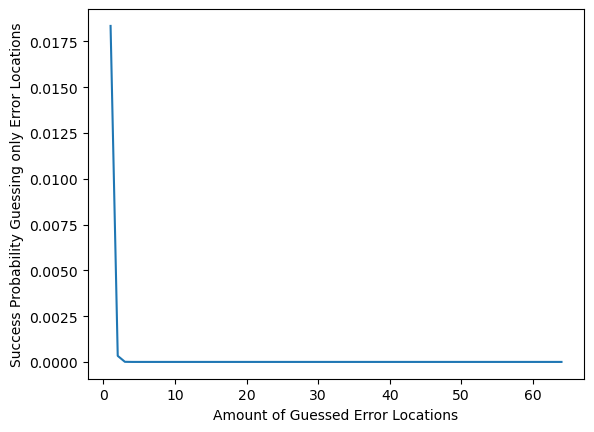

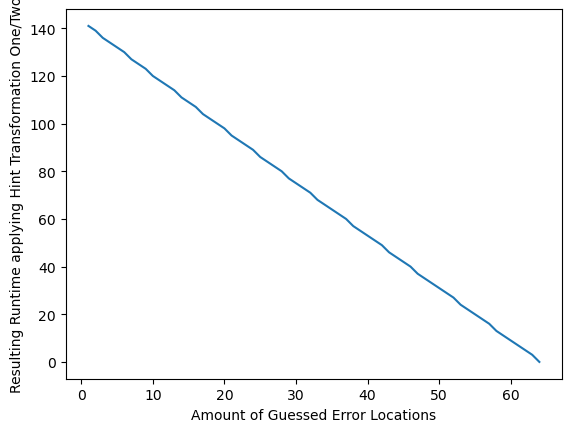

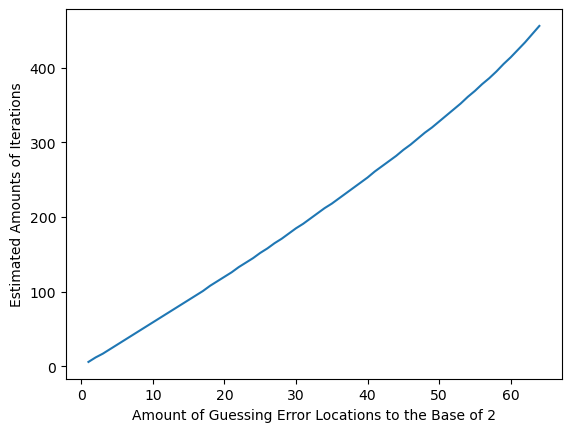

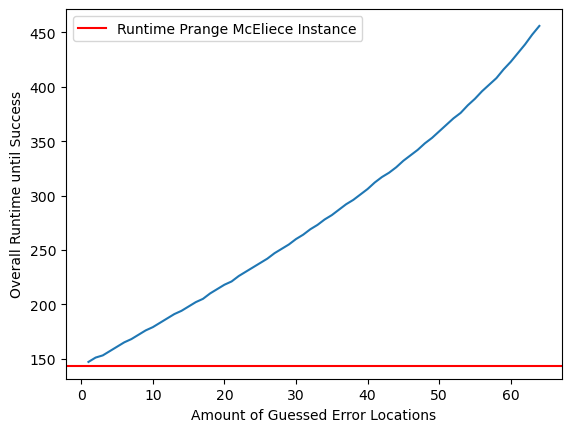


>> SO EVEN WHEN THE TERMINATE EVERY PRANGE INSTANCE AFTER THE ESTIMATED AMOUNT OF ITERATIONS, WE GET A RUNTIME THAT IS WORSE THAN THE NORMAL PRANGE.


In [24]:
# --- ATTEMPTS GUESSING ERROR-LOCATIONS WITH TRANSFORMATIONS --- #

from matplotlib import pyplot as plt
import numpy as np 

# Input: Dimensions n, k and w = wt_H(e)
# Output: Displaying the Resulting Runtime trying Guessing Error Locations
def distribution_guessing_error_locations(n, k, w):
    x = []
    y = []
    z = []
    iterations = []
    overall_runtime = []
    
    for amount_of_hints in range(1, w+1):
        current_probability = hypergeometric_distribution(n, w, amount_of_hints, amount_of_hints)
        x.append(amount_of_hints)
        y.append(float(current_probability))
        z.append(logarithmic_runtime_complexity_prange(int(n-amount_of_hints), int(k-amount_of_hints), int(w-amount_of_hints)))
        iterations.append(round(log(round(1/current_probability), 2)))
        overall_runtime.append(round(log(round(1/current_probability), 2)) + logarithmic_runtime_complexity_prange(int(n-amount_of_hints), int(k-amount_of_hints), int(w-amount_of_hints)))

    x = np.array(x)
    y = np.array(y)
    z = np.array(z)
    iterations = np.array(iterations)
    overall_runtime = np.array(overall_runtime)
    
    plt.plot(x,y)
    plt.xlabel('Amount of Guessed Error Locations')
    plt.ylabel('Success Probability Guessing only Error Locations')
    plt.show()
    
    plt.plot(x,z)
    plt.xlabel('Amount of Guessed Error Locations')
    plt.ylabel('Resulting Runtime applying Hint Transformation One/Two')
    plt.show()
    
    plt.plot(x,iterations)
    plt.xlabel('Amount of Guessing Error Locations to the Base of 2')
    plt.ylabel('Estimated Amounts of Iterations')
    plt.show()
    
    plt.plot(x,overall_runtime)
    plt.axhline(y=logarithmic_runtime_complexity_prange(n, k, w), color='r', linestyle='-', label='Runtime Prange McEliece Instance')
    plt.xlabel('Amount of Guessed Error Locations')
    plt.ylabel('Overall Runtime until Success')
    plt.legend()
    plt.show()
    
    


# --- USAGE --- # 

n = 3488
k = 2720
w = 64

print("NOTE: INFORMATION-SET DECODING ALGORITHMS ARE BY FAR THE MOST EFFICIENT WAY OF SOLVING THE SYNDROME DECODING PROBLEM")
print("REPRESENTATIVELY WE USE THE RUNTIME COMPLEXITY OF PRANGE'S PRIMAL ISD")

print("\nWHEN GUESSING ERROR LOCATIONS OF E, WE SIMPLY INVERT THE LOCATIONS IN THE ERRORNOUS CODEWORD r")
print("WHEN WE GUESSING CORRECTLY THE ERROR E WE RECEIVE AS NEW RUNTIME TO THE BASE OF 2:", logarithmic_runtime_complexity_prange(n-1, k-1, w-1))
print("THE PROBABILITY OF GUESSING ONLY ONE LOCATION CORRECTLY IS:", float(w/n))
print("OTHERWISE WE DESTROY THE INSTANCE WITH A PROBABILITY OF", 1 - float(w/n))
print("BUT WE NEED", int(round(1/float(w/n))), "Iterations in the Average Case to find a Error Location.")
print("SO OVERALL WE GET A ESTIMATED RUNTIME OF", logarithmic_runtime_complexity_prange(n-1, k-1, w-1) + int(round(log(round(1/float(w/n)) , 2))), "TO THE BASE OF 2")
print(">> GUESSING ONE ERROR LOCATION IS WORSE THAN NORMAL PRANGE!")

print("\nNOW WE WILL HAVE A LOOK ON GUESSING SEVERAL ERROR-FREE LOCATIONS OF E AND APPLYING THE TRANSFORMATION OF HINT TYPE ONE/TWO:\n")
distribution_guessing_error_locations(n, k, w)

print("\n>> SO EVEN WHEN THE TERMINATE EVERY PRANGE INSTANCE AFTER THE ESTIMATED AMOUNT OF ITERATIONS, WE GET A RUNTIME THAT IS WORSE THAN THE NORMAL PRANGE.")

NOTE: INFORMATION-SET DECODING ALGORITHMS ARE BY FAR THE MOST EFFICIENT WAY OF SOLVING THE SYNDROME DECODING PROBLEM
REPRESENTATIVELY WE USE THE RUNTIME COMPLEXITY OF PRANGE'S PRIMAL ISD

WHEN GUESSING ERROR-FREE LOCATIONS OF E, WE SIMPLY INVERT THE LOCATIONS IN THE ERRORNOUS CODEWORD r
WHEN WE GUESSING CORRECTLY THE ERROR-LOCATION E WE RECEIVE AS NEW RUNTIME TO THE BASE OF 2: 143
THE PROBABILITY OF GUESSING ONLY ONE LOCATION CORRECTLY IS: 0.981651376146789
OTHERWISE WE DESTROY THE INSTANCE WITH A PROBABILITY OF 0.01834862385321101
>> GUESSING ONE ERROR-FREE LOCATION IS AS COMPLEX AS NORMAL PRANGE!

NOW WE WILL HAVE A LOOK ON GUESSING SEVERAL ERROR-FREE LOCATIONS OF E AND APPLYING THE TRANSFORMATION OF HINT TYPE THREE:



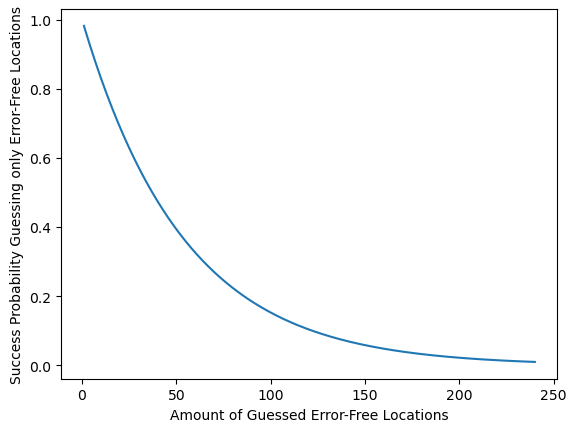

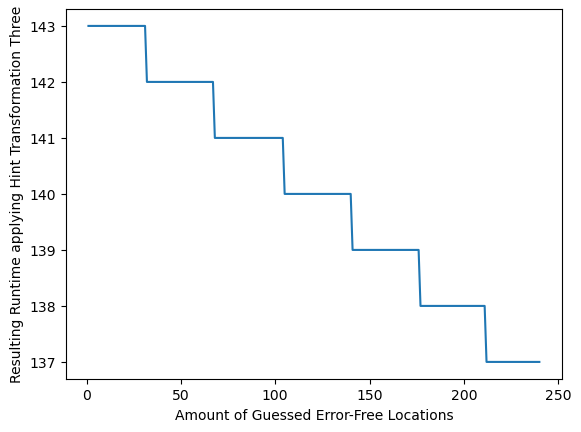

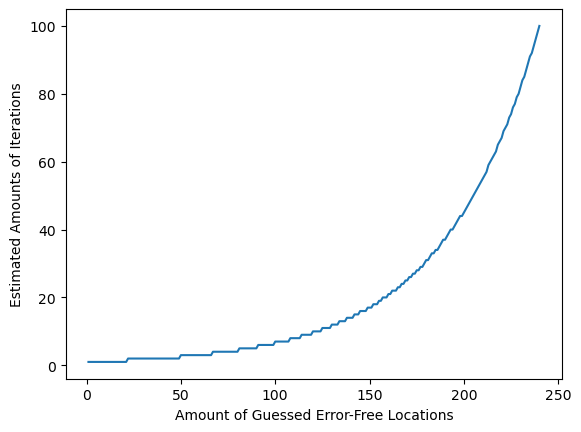

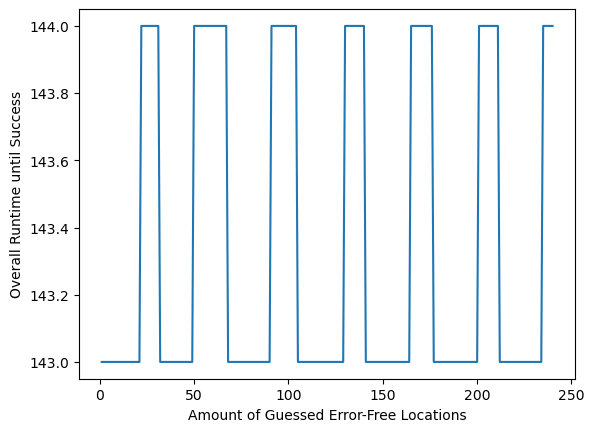


>> SO EVEN WHEN THE TERMINATE EVERY PRANGE INSTANCE AFTER THE ESTIMATED AMOUNT OF ITERATIONS, WE GET A RUNTIME THAT IS EQUAL OR WORSE THAN THE NORMAL PRANGE.


In [25]:
# --- GUESSING ERROR-FREE LOCATIONS WITH TRANSFORMATIONS --- #

from matplotlib import pyplot as plt
import numpy as np 

# Input: Dimensions n, k and w = wt_H(e)
# Output: Displaying the Resulting Runtime trying Guessing Error-Free Locations
def distribution_guessing_error_free_locations(n, k, w):
    x = []
    y = []
    z = []
    iterations = []
    overall_runtime = []
    
    amount_of_hints = 1 
    current_probability = 1 
    while True:
        if current_probability < 0.01:
            break
            
        current_probability = hypergeometric_distribution(n, n-w, amount_of_hints, amount_of_hints)
        x.append(amount_of_hints)
        y.append(float(current_probability))
        z.append(logarithmic_runtime_complexity_prange(int(n-amount_of_hints), int(k-amount_of_hints), w))
        iterations.append(round(1/current_probability))
        overall_runtime.append(round(log(round(1/current_probability), 2)) + logarithmic_runtime_complexity_prange(int(n-amount_of_hints), int(k-amount_of_hints), w))
        amount_of_hints = amount_of_hints + 1
    
    bound = 0
    for index in range(len(x)):
        if y[index] < 0.5:
            bound = x[index]
            break
    
    
    x = np.array(x)
    y = np.array(y)
    z = np.array(z)
    iterations = np.array(iterations)
    overall_runtime = np.array(overall_runtime)
    
    plt.plot(x,y)
    plt.xlabel('Amount of Guessed Error-Free Locations')
    plt.ylabel('Success Probability Guessing only Error-Free Locations')
    plt.show()
    
    plt.plot(x,z)
    plt.xlabel('Amount of Guessed Error-Free Locations')
    plt.ylabel('Resulting Runtime applying Hint Transformation Three')
    plt.show()
    
    plt.plot(x,iterations)
    plt.xlabel('Amount of Guessed Error-Free Locations')
    plt.ylabel('Estimated Amounts of Iterations')
    plt.show()
    
    plt.plot(x,overall_runtime)
    plt.xlabel('Amount of Guessed Error-Free Locations')
    plt.ylabel('Overall Runtime until Success')
    plt.show()
    
    

    
# --- USAGE --- #

n = 3488
k = 2720
w = 64

print("NOTE: INFORMATION-SET DECODING ALGORITHMS ARE BY FAR THE MOST EFFICIENT WAY OF SOLVING THE SYNDROME DECODING PROBLEM")
print("REPRESENTATIVELY WE USE THE RUNTIME COMPLEXITY OF PRANGE'S PRIMAL ISD")

print("\nWHEN GUESSING ERROR-FREE LOCATIONS OF E, WE SIMPLY INVERT THE LOCATIONS IN THE ERRORNOUS CODEWORD r")
print("WHEN WE GUESSING CORRECTLY THE ERROR-LOCATION E WE RECEIVE AS NEW RUNTIME TO THE BASE OF 2:", logarithmic_runtime_complexity_prange(n-1, k-1, w))
print("THE PROBABILITY OF GUESSING ONLY ONE LOCATION CORRECTLY IS:", float(1 - w/n))
print("OTHERWISE WE DESTROY THE INSTANCE WITH A PROBABILITY OF", float(w/n))
print(">> GUESSING ONE ERROR-FREE LOCATION IS AS COMPLEX AS NORMAL PRANGE!")

print("\nNOW WE WILL HAVE A LOOK ON GUESSING SEVERAL ERROR-FREE LOCATIONS OF E AND APPLYING THE TRANSFORMATION OF HINT TYPE THREE:\n")
distribution_guessing_error_free_locations(n, k, w)

print("\n>> SO EVEN WHEN THE TERMINATE EVERY PRANGE INSTANCE AFTER THE ESTIMATED AMOUNT OF ITERATIONS, WE GET A RUNTIME THAT IS EQUAL OR WORSE THAN THE NORMAL PRANGE.")

NOW WE WILL HAVE A LOOK ON THE HAMMING WEIGHT OF THE REMAINING E WHEN WE ARE DELETING RANDOMLY 50 ERROR LOCATIONS
FOR THIS PURPOSE WE HAVE TO DETERMINE WHETHER THE DECODING IS STILL UNIQUE. WE SHOWED THAT WITH PROBABILITY ALMOST 1, K DOESN'T CHANGE
WHEN DELETING COLUMNS OF THE GENERATOR MATRIX G. FOR THIS REASON THE PACKING RADIUS REDUCES LIKE WE SEE IN THE FOLLOWING GRAPHIC:


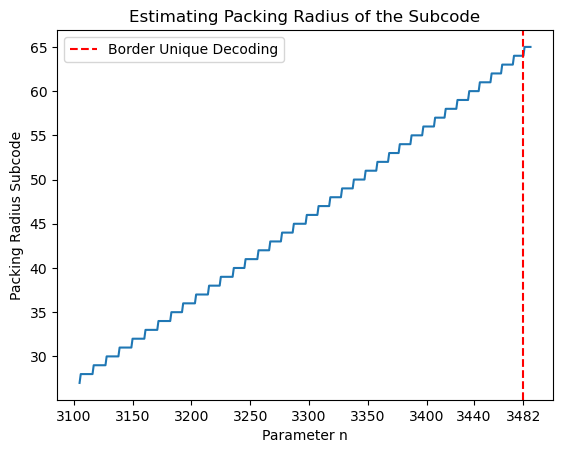

THE BORDER OF UNIQUE DECODING IS DETERMINE THROUGH THE ORIGINAL HAMMING DISTANCE OF E SINCE IT'S NOT SO LIKELY TO HIT ERROR POSITIONS OF E. SEE HERE:


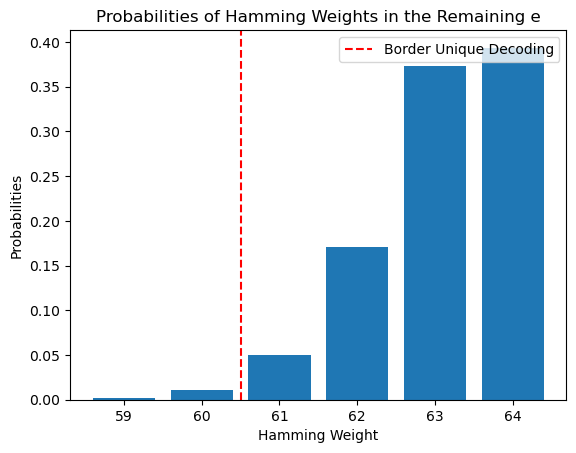

THE PROBABILITY THAT THE REMAINING ERROR IS UNIQUELY DECODABLE IS: 0.012624324544558713

THE RUNTIME IS CALCULATED THROUGH THE MODIFIED PRIMAL PRANGE INFORMATION-SET DECODING ALGORITHM INCLUDING THE LIST-DECODING STEP IF NECESSARY!


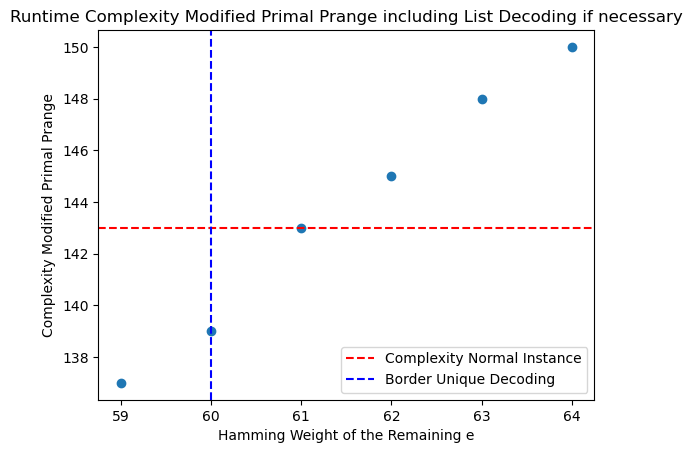

THE EXPECTED RUNTIME IS THEREFORE: 147.87228144611825 TO THE BASE OF 2


In [26]:
# --- ATTEMPTS GUESSING SUB-ERRORS AND THEIR HAMMING WEIGHT --- #

import numpy as np 
import random 
from matplotlib import pyplot as plt

# Input: n, k, wt_H(e) = w and the amount of hints
# Output: The packing radius when guessing amount of hints random locations e and deleting these columns
def determine_unique_decoding(n, k, w, amount_of_hints):
    for index in range(w, 0, -1):
        if is_unique_decoding(int(n-amount_of_hints), k, index):
            return index 

        
        
# Input: Dimensions n, k and the wt_H(e) = w 
# Output: Displaying the Distribution of the Packing Radius, when changing the n
def distribution_approximated_packing_radius(n, k, w):
    x = []
    y = []
    for index in range(0, floor((n-k)/2)):
        x.append(n-index)
        y.append(approximated_packing_radius(n-index,k))
    
    x = x[::-1]
    y = y[::-1]
    biggest_n = 0
    for index in range(len(y)):
        if y[index] <= w:
            biggest_n = x[index]
            
    x = np.array(x)
    y = np.array(y)
    plt.xticks([3100, 3150, 3200, 3250, 3300, 3350, 3400, 3440, biggest_n])
    plt.plot(x,y)
    plt.axvline(x = biggest_n, color = 'r', linestyle = '--', label='Border Unique Decoding')
    plt.title('Estimating Packing Radius of the Subcode')
    plt.xlabel('Parameter n')
    plt.ylabel('Packing Radius Subcode')
    plt.legend()
    plt.show()

    
    
# Input: n, k, wt_H(e) = w and the amount of hints
# Output: Returning the most common values for the remaining e, their probabilities and the probability of all hamming weights
def most_common_hamming_weights(n, k, w, amount_of_hints):
    indices = []
    values = []
    for index in range(w+1):
        current_probability = hypergeometric_distribution(n, w, amount_of_hints, index)
        indices.append(w - index)
        values.append(current_probability)
    
    indices = indices[::-1]
    values = values[::-1]    
    
    most_common_indices = []
    most_common_values = []
    for index in indices:
        if float(values[index]) >= 0.001:
            most_common_indices.append(index)
            most_common_values.append(float(values[index]))
    
    return most_common_indices, most_common_values, values        

    
    
# Input: n, k, wt_H(e) = w and the amount of hints
# Output: Displaying the amount of expected Hamming Weight and the Probability of the remaining e
def distribution_guessing_density_remaining_error(n, k, w, amount_of_hints):
    most_common_indices, most_common_values, values = most_common_hamming_weights(n, k, w, amount_of_hints)
    unique_decoding = determine_unique_decoding(n, k, w, amount_of_hints)
    
    x = np.array(most_common_indices)
    y = np.array(most_common_values)
    plt.bar(x,y) 
    plt.axvline(x = unique_decoding + 0.5, color = 'r', linestyle = '--', label='Border Unique Decoding')
    plt.title('Probabilities of Hamming Weights in the Remaining e')
    plt.xlabel('Hamming Weight')
    plt.ylabel('Probabilities')
    plt.legend()
    plt.show()
    print("THE PROBABILITY THAT THE REMAINING ERROR IS UNIQUELY DECODABLE IS:", float(sum(values[:unique_decoding+1])))
    

    
# Input: n, k, wt_H(e) = w and the amount of hints
# Output: Resulting Runtime Complexities of the Modified Primal Prange's ISD for the new Instance   
def complexity_unique_decodable_remaining_e(n, k, w, amount_of_hints):  
    most_common_indices, most_common_values, values = most_common_hamming_weights(n, k, w, amount_of_hints)
    if most_common_values == []:
        print(">> PROBABILITY IS TO SMALL!")
    
    unique_decoding = determine_unique_decoding(n, k, w, amount_of_hints)
    x = []
    y = []
    expected_runtime = 0
    
    for index in range(len(most_common_indices)):
        if most_common_indices[index] <= unique_decoding:
            x.append(most_common_indices[index])
            y.append(logarithmic_runtime_complexity_prange(int(n-amount_of_hints), k, most_common_indices[index]))
            expected_runtime += most_common_values[index] * logarithmic_runtime_complexity_prange(int(n-amount_of_hints), k, most_common_indices[index])
        else:
            x.append(most_common_indices[index])
            y.append(logarithmic_runtime_complexity_list_decoding_prange(int(n-amount_of_hints), k, most_common_indices[index]))
            expected_runtime += most_common_values[index] * logarithmic_runtime_complexity_list_decoding_prange(int(n-amount_of_hints), k, most_common_indices[index])
            
    x = np.array(x)
    y = np.array(y)
    plt.plot(x, y, 'o')
    plt.axhline(y = logarithmic_runtime_complexity_prange(n, k, w), color = 'r', linestyle = '--', label='Complexity Normal Instance')
    plt.axvline(x = unique_decoding, color = 'b', linestyle = '--', label='Border Unique Decoding')
    plt.title('Runtime Complexity Modified Primal Prange including List Decoding if necessary')
    plt.xlabel('Hamming Weight of the Remaining e')
    plt.ylabel('Complexity Modified Primal Prange')
    plt.legend()
    plt.show()
    print("THE EXPECTED RUNTIME IS THEREFORE:", expected_runtime, "TO THE BASE OF 2")
    
    
    
# --- USAGE --- # 
n = 3488
k = 2720
w = 64
amount_of_hints = 50

print("NOW WE WILL HAVE A LOOK ON THE HAMMING WEIGHT OF THE REMAINING E WHEN WE ARE DELETING RANDOMLY", amount_of_hints, "ERROR LOCATIONS")
print("FOR THIS PURPOSE WE HAVE TO DETERMINE WHETHER THE DECODING IS STILL UNIQUE. WE SHOWED THAT WITH PROBABILITY ALMOST 1, K DOESN'T CHANGE")
print("WHEN DELETING COLUMNS OF THE GENERATOR MATRIX G. FOR THIS REASON THE PACKING RADIUS REDUCES LIKE WE SEE IN THE FOLLOWING GRAPHIC:")
distribution_approximated_packing_radius(n, k, w)

print("THE BORDER OF UNIQUE DECODING IS DETERMINE THROUGH THE ORIGINAL HAMMING DISTANCE OF E SINCE IT'S NOT SO LIKELY TO HIT ERROR POSITIONS OF E. SEE HERE:")
distribution_guessing_density_remaining_error(n, k, w, amount_of_hints)

print("\nTHE RUNTIME IS CALCULATED THROUGH THE MODIFIED PRIMAL PRANGE INFORMATION-SET DECODING ALGORITHM INCLUDING THE LIST-DECODING STEP IF NECESSARY!")
complexity_unique_decodable_remaining_e(n, k, w, amount_of_hints)